We want to show the Electric, Magnetic, and Pixel Intensity from Swarm B

In [1]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp

import scienceplots

plt.style.use(['science','no-latex'])
alt=150

Load IGRF coefficients ...


In [2]:
time_array=(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6))

In [3]:
#From documentation link
def requester(sc_collection, measurement, residual, sampling_step=None, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if residual == True:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                residuals=True,
                sampling_step=sampling_step,
            )
        else:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                sampling_step=sampling_step,
            )
        data = request.get_between(time_array[0], time_array[1], **kwargs) #sets to get data between the first and last value in the time tuple
        df = data.as_dataframe()
    except:
        df = []
    return df

In [4]:
def arrangement(time, array, shape):  # arranges B into a useable format for use later
    barranged = np.zeros((len(time), shape))
    # Re-arranges into proper (n x 3 ) matricies, ugly but works
    for j in range(len(time)):
        for k in range(shape):
            barranged[j][k] = array[j][k]
    return barranged

In [5]:
def unit_array(array):
    arraysum = np.sum(np.abs(array), axis=1)
    # Normalizes and finds unitary
    array_unit = array / arraysum[:, np.newaxis]  # normalizes
    return array_unit

In [6]:
#Lets do B first
ds = requester( 
    "SW_OPER_MAGB_HR_1B", #Mag B, high resolution, 50Hz B (Magnetic field)
    "B_NEC", #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) 
print(ds)
BNEC=ds["B_NEC_res_CHAOS"]
Btime = BNEC.index.to_numpy()
BNEC = arrangement(Btime, ds["B_NEC_res_CHAOS"], 3)




                                                                 B_NEC_res_CHAOS  \
Timestamp                                                                          
2022-12-19 14:04:00.010546923  [82.78851767348624, -138.16134622453387, 36.38...   
2022-12-19 14:04:00.030546904  [82.75096559278973, -138.28340700805347, 36.37...   
2022-12-19 14:04:00.050546885  [82.6129967472325, -138.48937014403464, 36.388...   
2022-12-19 14:04:00.070546865  [82.54693945306826, -138.7562176351937, 36.417...   
2022-12-19 14:04:00.090546846  [82.52484444328365, -139.05127858931246, 36.41...   
...                                                                          ...   
2022-12-19 14:05:59.902414083  [10.672619929264329, 15.12969049616413, -9.467...   
2022-12-19 14:05:59.922414064  [10.6323925845536, 15.15063925961067, -9.47605...   
2022-12-19 14:05:59.942414045  [10.628683967614052, 15.20196943415067, -9.441...   
2022-12-19 14:05:59.962414026  [10.611746169222897, 15.266420895678039, -9.4

C:\Users\1101w\AppData\Local\Temp\ipykernel_8752\2246279540.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  barranged[j][k] = array[j][k]


In [7]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def quaternion_inverse_scipy(q):
    # Ensure q is a numpy array
    q = np.asarray(q)
    
    # Create a Rotation object from the quaternion
    rotation = R.from_quat(q)  # Note: scipy uses [x, y, z, w] format
    
    # Compute the inverse rotation
    inverse_rotation = rotation.inv()
    
    
    return inverse_rotation

In [8]:

def find_closest_indices(times1, times2):
    # Convert to numpy arrays
    times1 = np.array(times1)
    times2 = np.array(times2)
    
    # Compute the differences between each time in times1 and all times in times2
    # Resulting in a 2D array where each row contains the absolute differences for one time in times1
    differences = np.abs(times1[:, None] - times2)
    
    # Find the index of the minimum difference for each time in times1
    closest_indices = np.argmin(differences, axis=1)
    
    return closest_indices

In [9]:
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
import geopack.geopack as gp
def footprint(time, latitude, longitude, altitude, alt,vsw= [-400,0,0]):
    """
    time, datetime, time for magnetic data for footprint
    vsw velocity of solar wind, tuple of x,y,z
    longitude of satellite in degrees
    latitude of satellite in degrees
    altitude of satellite in km from centre of earth (should be above ~6371)
    THIS CODE ONLY Works in the NOrthern hemisphere

    """
    def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
    def x(t, params_x):
        return cubic(t, *params_x)

    def y(t, params_y):
        return cubic(t, *params_y)

    def z(t, params_z):
        return cubic(t, *params_z)
    def radius(t, params_x, params_y, params_z):
        return np.sqrt(x(t, params_x)**2 + y(t, params_y)**2 + z(t, params_z)**2)
    
    def curve_fit_func(xx,yy,zz, differencealt):
        
        r = np.linspace(1, 1.5, 100000)# construct an array of radiuses from 1-1.5

        radius_data=np.sqrt(xx**2+yy**2+zz**2)

        params_x, _ = curve_fit(cubic, radius_data, xx) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy)
        params_z, _ = curve_fit(cubic, radius_data, zz)

        

        index_closest=np.argmin(np.abs(radius(r, params_x, params_y, params_z)-(alt-differencealt+6371)/6371))#Find the index that produces the closest radius to the altitude

        return x(r[index_closest],params_x ),y(r[index_closest],params_y ),z(r[index_closest],params_z )
    
    t1 = time
    t0 = datetime(1970,1,1) #epoch
    ut = (t1-t0).total_seconds()
    lat_sat=np.deg2rad(latitude)
    lon_sat=np.deg2rad(longitude) #converts to radii
    gp.recalc(ut)
    r, theta= gp.geodgeo(altitude,lat_sat,1) #this r accounts for earths oblateness, so we need to find the difference between my 6371 assumption and the real value and account for that
    differencearray= (altitude+6371)-r
    x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian
    

    x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

    x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array
    for index in range(len(x_gsm)):
        x_foot_int, y_foot_int, z_foot_int, xx, _,zz = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=1.6, maxloop=3000 ) #traces each set of lat,lon,alt outward
        _, _, _, xx2,yy2,zz2 = gp.trace(x_foot_int, y_foot_int, z_foot_int, dir=-1,rlim=100, maxloop=1000 )#Traces inward

        x_foot[index],y_foot[index],z_foot[index] = curve_fit_func(xx2,yy2,zz2, differencearray[index])


            

    x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

    alt_sat_done, lat_sat_done,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
    for index in range(len(x_done)):
        
        r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

        alt_sat_done[index], lat_sat_done[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

    print(alt_sat_done, 'altitude derived from fit')

    if np.any(np.abs(alt_sat_done - alt) > 5):
        raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")
    print(np.rad2deg(lon_sat_done)-360,np.rad2deg(lat_sat_done) , 'lat and lon' )
    sat_lla=np.array([ np.rad2deg(lat_sat_done), np.rad2deg(lon_sat_done)-360,  alt_sat_done])
    return sat_lla

In [10]:
measurements_E = [
        "VsatN",
        "VsatE",
        "VsatC",
        "Evx",
        "Evy",
        "Evz",
        "Vixv",
        "Viy",
        "Viz",
        "Quality_flags",
    ]
ds = requester( 
    "SW_EXPT_EFIB_TCT16", #Mag B, high resolution, 50Hz B (Magnetic field)
    measurements_E, #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) 
print(ds)
dsB = requester( 
    'SW_OPER_MAGB_HR_1B', #Mag B, high resolution, 50Hz B (Magnetic field)
    ["q_NEC_CRF"], #Magnetic field in NEC coordinates
    False, 
    asynchronous=False,
    show_progress=False)

latitude, longitude, altitude = dsB['Latitude'].to_numpy(), dsB['Longitude'].to_numpy(),  (dsB["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data


                                     VsatN   Longitude       Evz         Viz  \
Timestamp                                                                      
2022-12-19 14:04:00.006750107 -7580.783203 -118.103455  8.471214   41.156399   
2022-12-19 14:04:00.068749905 -7580.793457 -118.102829  8.235891   20.354244   
2022-12-19 14:04:00.131750107 -7580.804199 -118.102180  8.086688   55.447094   
2022-12-19 14:04:00.193749905 -7580.814453 -118.101555  8.649044   44.507736   
2022-12-19 14:04:00.256750107 -7580.824707 -118.100914  9.233665 -116.582336   
...                                    ...         ...       ...         ...   
2022-12-19 14:05:59.693749905 -7594.200195 -117.261467 -1.469386   47.678398   
2022-12-19 14:05:59.756750107 -7594.205078 -117.261177 -1.843340   49.343391   
2022-12-19 14:05:59.818749905 -7594.209473 -117.260887 -2.056162    7.718913   
2022-12-19 14:05:59.881750107 -7594.214355 -117.260597 -2.261700  115.148308   
2022-12-19 14:05:59.943749905 -7594.2187

In [11]:
sat_lla_B=footprint(time_array[0], latitude, longitude, altitude, alt, vsw=[-345,12,-12])


[150.10593799 150.10559368 150.13709334 ... 150.22250012 150.22209182
 150.22168203] altitude derived from fit
[-117.84339652 -117.84318555 -117.84300388 ... -116.97064423 -116.97054795
 -116.97045158] [65.8407588  65.8395288  65.83825996 ... 58.4807523  58.47952908
 58.47830586] lat and lon


In [12]:
print(sat_lla_B)

[[  65.8407588    65.8395288    65.83825996 ...   58.4807523
    58.47952908   58.47830586]
 [-117.84339652 -117.84318555 -117.84300388 ... -116.97064423
  -116.97054795 -116.97045158]
 [ 150.10593799  150.10559368  150.13709334 ...  150.22250012
   150.22209182  150.22168203]]


In [13]:
indicies=find_closest_indices(ds.index, dsB.index)
quatnecrf=dsB["q_NEC_CRF"].to_numpy()[indicies]
quaternions = []
Esat=np.array([ds["Evx"] , ds["Evy"], ds["Evz"]]).T
vsat=np.array([ds["Vixv"] , ds["Viy"], ds["Viz"]]).T
Etime = ds.index
ENEC=[]
VNEC=[]
for i in range(len(quatnecrf)):
    inverse_quat = quaternion_inverse_scipy(dsB["q_NEC_CRF"].to_numpy()[indicies][i])
    rot_NEC_V= inverse_quat.apply(Esat[i])
    ENEC.append(rot_NEC_V)

    rot_NEC_V= inverse_quat.apply(vsat[i])
    VNEC.append(rot_NEC_V)

ENEC=np.array(ENEC)
VNEC=np.array(VNEC)


Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing 

Lets define the imager

In [14]:
from scipy.interpolate import CubicSpline
cs_lat = CubicSpline( Btime, sat_lla_B[0])
cs_lon = CubicSpline( Btime, sat_lla_B[1])
cs_alt = CubicSpline( Btime, sat_lla_B[2])
print(ds['Latitude'].to_numpy())
print(latitude)
sat_lla_E= np.array([cs_lat(Etime), cs_lon(Etime),  cs_alt(Etime)]) #km  # Gets Emphermis data latitude, longitude, altitude


[65.46734  65.46342  65.45944  ... 57.887745 57.88376  57.879833]
[65.4075031 65.406239  65.4049749 ... 57.8202265 57.8189604 57.8176943]


In [15]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time_range=time_array, colors='r')


Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


In [16]:

#sat_lla_E=footprint(time_array[0],latitude_E, longitude_E, altitude_E, alt, vsw=[-345,12,-12])

conjunction_obj = asilib.Conjunction(asi, (np.array(Etime), sat_lla_E.T))

In [17]:
#Now lets 

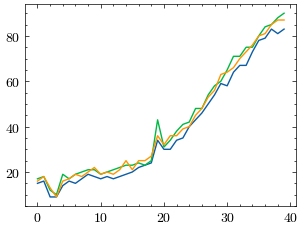

In [18]:
sat_azimuth_elevation, sat_azel_pixels = conjunction_obj.map_azel()
area_intensity = conjunction_obj.intensity()
area_mask = conjunction_obj.equal_area(box=(10,10))
# Need to change masked NaNs to 0s so we can plot the rectangular area contours.
area_mask[np.where(np.isnan(area_mask))] = 0
plt.plot(area_intensity) #This gives us a resolution of 3Hz.


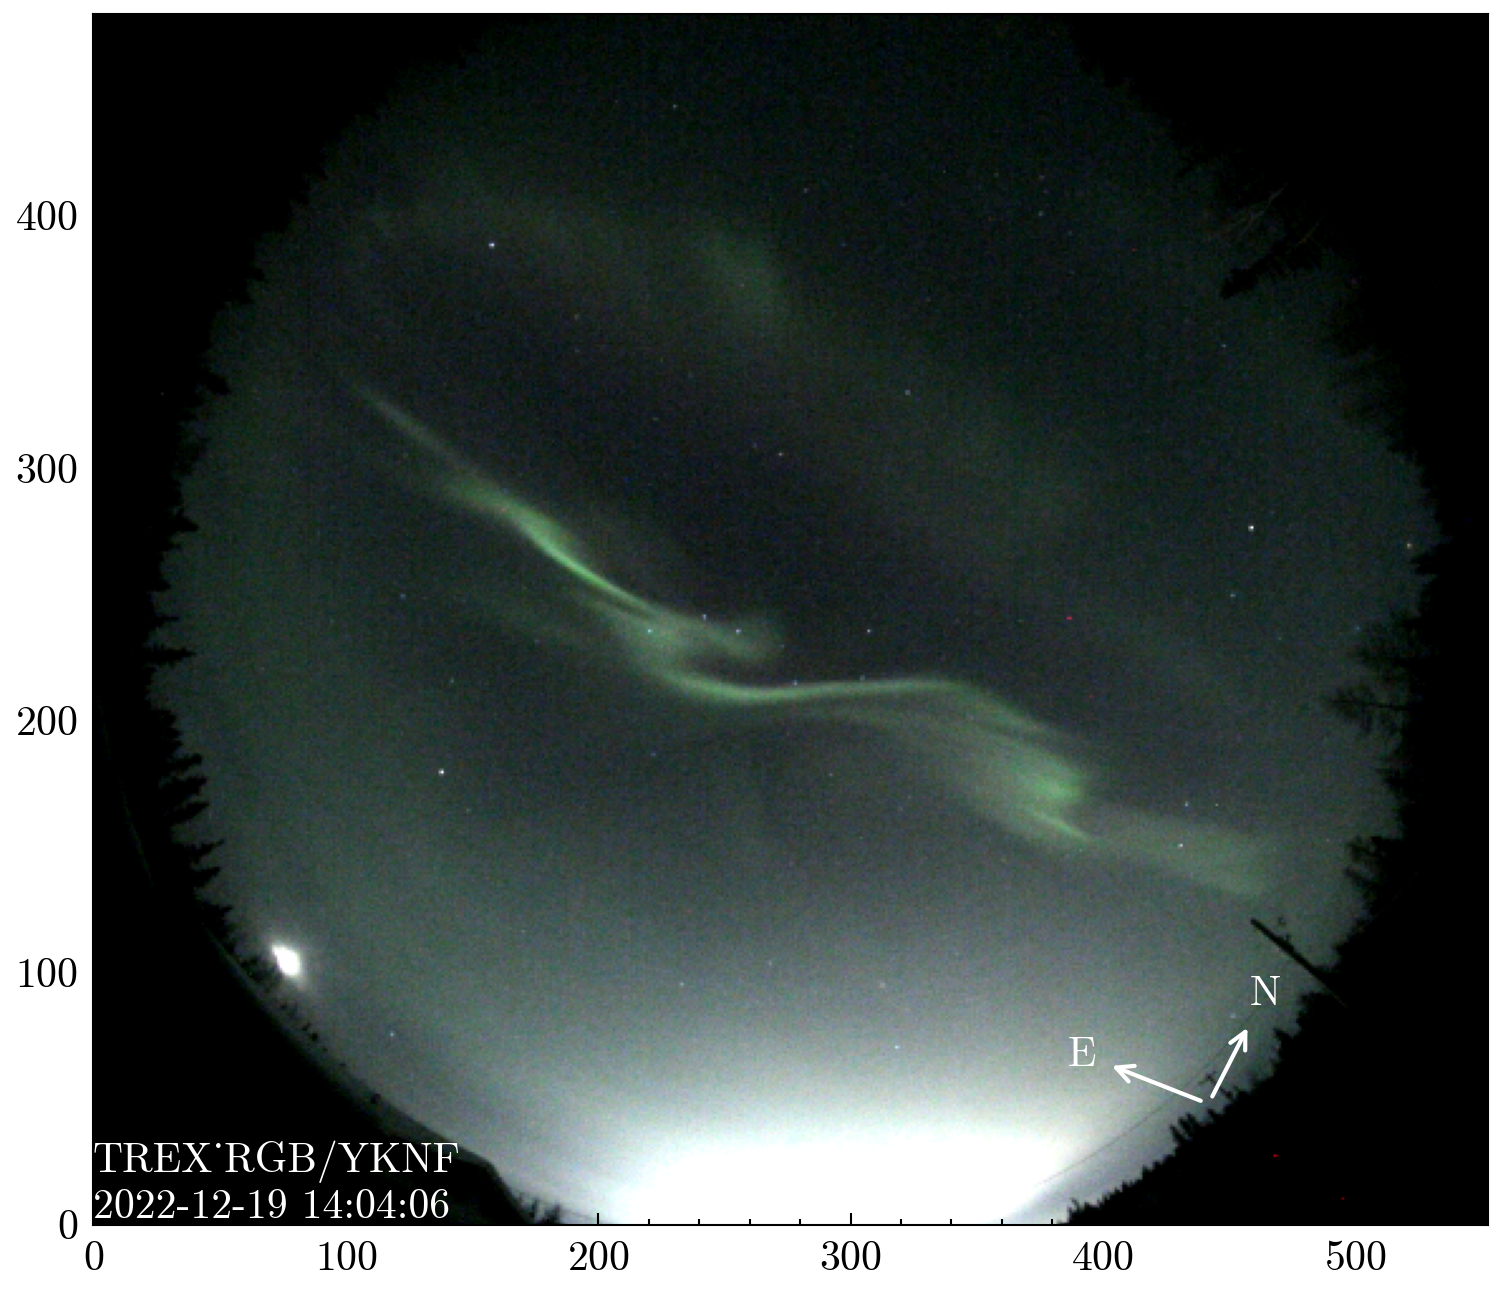

In [19]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=datetime(2022,12,19,14,4,5), colors='rgb')

ax, im_good = asi_single.plot_fisheye(ax=ax)


[[-118.50009  -118.50009  -118.50009  ... -118.50009  -118.50009
  -118.50009 ]
 [-118.50009  -118.50009  -118.50009  ... -119.98486  -119.98486
  -119.98486 ]
 [-118.08197  -118.08197  -118.08197  ... -120.369446 -120.369446
  -120.369446]
 ...
 [-105.23822  -105.23822  -105.23822  ... -111.73367  -111.73367
  -111.73367 ]
 [-105.41092  -105.41092  -105.41092  ... -111.4859   -111.4859
  -111.4859  ]
 [-105.076416 -105.076416 -105.076416 ... -105.076416 -105.076416
  -105.076416]]


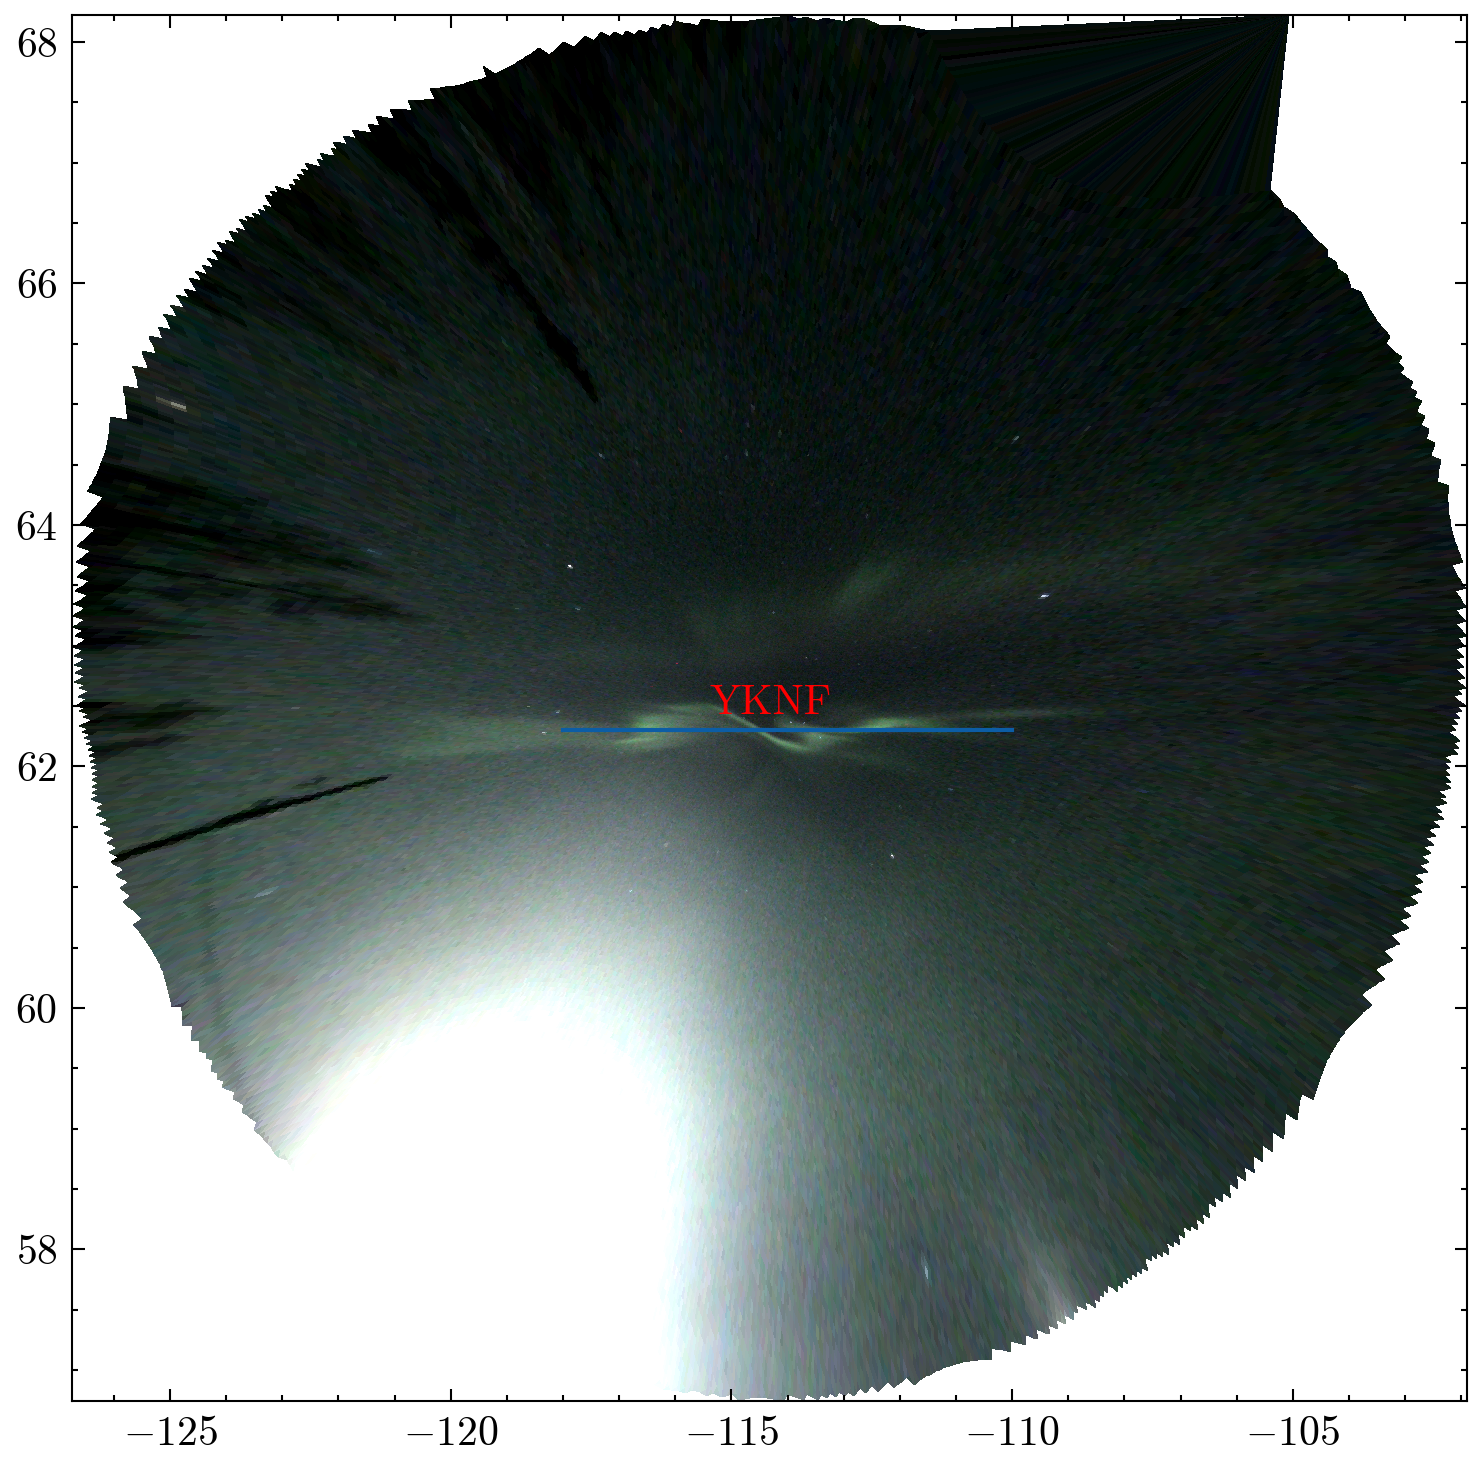

In [106]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax, im_good = asi_single.plot_map(ax=ax)
coords=im_good.get_coordinates()
x_coords=coords[:,:,0]
y_coords=coords[:,:,1]
print(x_coords)
x = np.linspace(-118, -110, 200)
y= np.linspace(62.30, 62.3, 200)
plt.plot(x,y)


In [107]:

R=6371.0+alt
# Convert degrees to radians
def deg2rad(deg):
    return deg * np.pi / 180.0

# Haversine formula to calculate distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    dlat = deg2rad(lat2 - lat1)
    dlon = deg2rad(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# grid_lats, grid_lons: 2D arrays representing the latitude and longitude grid
# line_lats, line_lons: 1D arrays representing the latitude and longitude of the line

def find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons):
    closest_indices = []
    for lat, lon in zip(line_lats, line_lons):
        # Calculate the distance from the current line point to all grid points
        distances = haversine(grid_lats, grid_lons, lat, lon)
        
        # Find the index of the minimum distance
        min_index = np.unravel_index(np.argmin(distances), distances.shape)
        closest_indices.append(min_index)
    
    return closest_indices

# Example usage
grid_lats = y_coords
grid_lons = x_coords

line_lats = y
line_lons = x

closest_indices = np.transpose(find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons))
print(np.shape(closest_indices))


(2, 200)


In [108]:
print(closest_indices)
print(np.shape(grid_lons))
print(np.shape(grid_lats))

[[154 155 155 155 155 156 156 156 157 157 157 158 158 158 159 159 159 160
  160 161 161 161 162 162 163 163 163 164 165 165 166 166 166 167 167 168
  169 169 170 170 171 172 172 173 173 174 175 175 176 177 178 178 179 180
  180 181 182 183 184 184 185 186 187 188 189 190 190 191 192 193 194 195
  196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 213 214
  215 216 217 218 219 221 222 223 224 225 226 227 229 230 231 232 233 234
  235 236 238 239 240 241 242 243 244 245 246 247 248 250 251 252 253 254
  255 256 257 258 259 260 261 262 263 264 265 265 266 267 268 269 270 271
  272 273 273 274 275 276 277 277 278 279 280 281 281 282 283 284 284 285
  286 286 287 288 289 289 290 291 291 292 293 293 294 294 295 296 296 297
  297 298 298 299 300 300 301 301 302 302 303 303 304 304 305 306 306 306
  307 307]
 [425 424 423 422 421 420 419 418 417 416 415 414 413 412 411 409 408 407
  406 405 404 402 401 400 399 397 396 395 394 392 391 389 388 387 385 384
  382 381 379 378 376 375 3

In [109]:
print(grid_lons[closest_indices[0], closest_indices[1] ])

[-118.01596  -117.958466 -117.92151  -117.88504  -117.84906  -117.79474
 -117.75983  -117.7254   -117.67334  -117.63992  -117.6069   -117.556946
 -117.52487  -117.493164 -117.44516  -117.38385  -117.3537   -117.30798
 -117.278625 -117.2341   -117.205505 -117.14923  -117.10666  -117.079346
 -117.03781  -116.98474  -116.95862  -116.91882  -116.87958  -116.829346
 -116.79132  -116.742676 -116.71866  -116.68204  -116.63519  -116.59961
 -116.5419   -116.5195   -116.46332  -116.44153  -116.38678  -116.354095
 -116.312164 -116.28027  -116.23935  -116.18814  -116.15753  -116.118164
 -116.06891  -116.020386 -115.99133  -115.95395  -115.907104 -115.8609
 -115.82492  -115.797516 -115.75275  -115.70856  -115.66492  -115.6308
 -115.58801  -115.545715 -115.503845 -115.46246  -115.42145  -115.38086
 -115.34897  -115.30902  -115.26941  -115.2301   -115.1911   -115.152435
 -115.09888  -115.06085  -115.02307  -114.98547  -114.94815  -114.91101
 -114.859436 -114.82272  -114.786194 -114.74982  -114.69913 

In [110]:
print(grid_lats[closest_indices[0], closest_indices[1] ])

[62.299892 62.306885 62.30382  62.30077  62.297726 62.30448  62.30142
 62.29836  62.30493  62.301857 62.29879  62.305187 62.302105 62.299034
 62.30527  62.299107 62.29604  62.302105 62.299023 62.30497  62.30188
 62.295723 62.30152  62.29844  62.304134 62.29796  62.294884 62.300446
 62.30593  62.299747 62.305126 62.298946 62.295864 62.301136 62.29497
 62.300156 62.302177 62.299088 62.30103  62.297943 62.29981  62.3047
 62.29852  62.303337 62.29716  62.29882  62.303513 62.297337 62.298874
 62.300358 62.304886 62.2987   62.300076 62.301403 62.295216 62.299583
 62.300816 62.302002 62.303146 62.29694  62.298035 62.299088 62.300102
 62.301083 62.30202  62.302925 62.29668  62.297543 62.298367 62.29916
 62.29992  62.300648 62.298195 62.298855 62.299484 62.300083 62.30065
 62.301193 62.298523 62.299004 62.299454 62.299877 62.29706  62.297424
 62.29776  62.29807  62.30187  62.30211  62.302326 62.302517 62.29939
 62.299522 62.299625 62.296375 62.29642  62.303158 62.30315  62.299736
 62.299664 62.

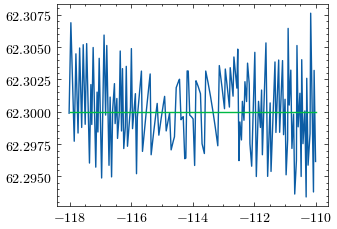

In [111]:
#plt.plot(line_lons, line_lats)
plt.plot(grid_lons[closest_indices[0], closest_indices[1] ],grid_lats[closest_indices[0], closest_indices[1] ] )
plt.plot( line_lons, line_lats)

Downloaded 20221219_1404_yknf_rgb-08_full.h5.
Downloaded 20221219_1405_yknf_rgb-08_full.h5.
Downloaded rgb_skymap_yknf_20220913-%2B_v01.sav.
Downloaded rgb_skymap_yknf_20230114-%2B_v01.sav.



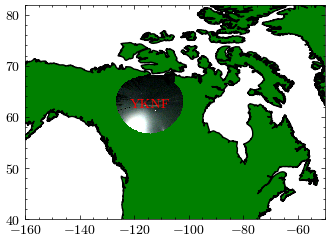

In [113]:

x_1 = np.linspace(-119, -107, 800)
y_1= np.linspace(62.3, 62.3, 800)

x_2 = np.linspace(-114, -114, 800)
y_2= np.linspace(59, 66, 800)

asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time_range=(time_array[0], time_array[-1]), redownload=True)

pixel_closest_sat = []
pixel_closest_sat_track = []
pixel_closest_1 = []
pixel_closest_2 =[]
time_ewo = []
times= []
lats = []
lons = []

movie_generator = asi.animate_map_gen()


for i, (time, image, _, im) in enumerate(movie_generator):

    indices = np.where((Etime >= np.datetime64(time)) & (Etime <= np.datetime64((time +timedelta(seconds=3)))))[0]
    coords=im.get_coordinates()
    grid_lons=coords[:,:,0]
    grid_lats=coords[:,:,1]


    closest_indices = np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0][indices], sat_lla_E[1][indices]))
    for j in range(len(closest_indices[0])):
        pixel_closest_sat.append(image[closest_indices[0][j], closest_indices[1][j] , 1])
        times.append(Etime.to_numpy()[indices[j]])
        lats.append(sat_lla_E[0][indices[j]])
        lons.append( sat_lla_E[1][indices[j]])

    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_1, x_1))
    temp_1=[]
    for j in range(len(closest_indices[0])):
        temp_1.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_1.append(temp_1)


    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_2, x_2))
    temp_2=[]
    for j in range(len(closest_indices[0])):
        temp_2.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_2.append(temp_2)
    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0], sat_lla_E[1]))
    temp_3=[]
    for j in range(len(closest_indices[0])):
        temp_3.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_sat_track.append(temp_3)
    time_ewo.append(time)

    if i==39:
        break #due to run error TODO


[Timestamp('2022-12-19 14:05:00'), Timestamp('2022-12-19 14:05:00.303030303'), Timestamp('2022-12-19 14:05:00.606060606'), Timestamp('2022-12-19 14:05:00.909090909'), Timestamp('2022-12-19 14:05:01.212121212'), Timestamp('2022-12-19 14:05:01.515151515'), Timestamp('2022-12-19 14:05:01.818181818'), Timestamp('2022-12-19 14:05:02.121212121'), Timestamp('2022-12-19 14:05:02.424242424'), Timestamp('2022-12-19 14:05:02.727272727'), Timestamp('2022-12-19 14:05:03.030303030'), Timestamp('2022-12-19 14:05:03.333333333'), Timestamp('2022-12-19 14:05:03.636363636'), Timestamp('2022-12-19 14:05:03.939393939'), Timestamp('2022-12-19 14:05:04.242424242'), Timestamp('2022-12-19 14:05:04.545454545'), Timestamp('2022-12-19 14:05:04.848484848'), Timestamp('2022-12-19 14:05:05.151515151'), Timestamp('2022-12-19 14:05:05.454545454'), Timestamp('2022-12-19 14:05:05.757575757'), Timestamp('2022-12-19 14:05:06.060606060'), Timestamp('2022-12-19 14:05:06.363636363'), Timestamp('2022-12-19 14:05:06.666666666'

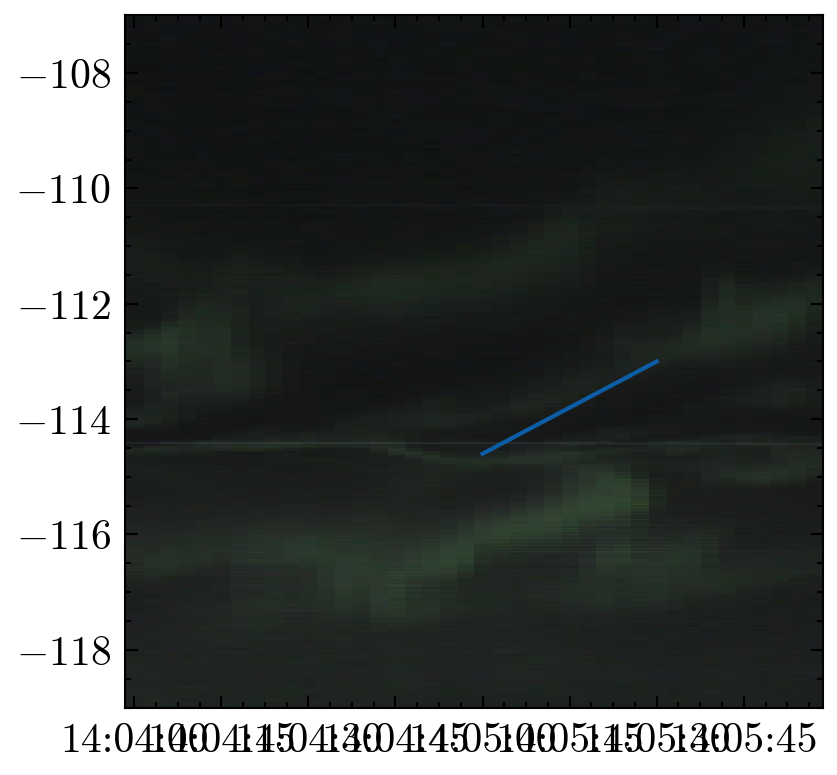

In [114]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
plt.pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_1, 1, 0 ))
import pandas as pd
y = pd.date_range(start='2022-12-19 14:05:00', end='2022-12-19 14:05:30', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-114.6,-113, 100))


[Timestamp('2022-12-19 14:05:00'), Timestamp('2022-12-19 14:05:00.555555555'), Timestamp('2022-12-19 14:05:01.111111111'), Timestamp('2022-12-19 14:05:01.666666666'), Timestamp('2022-12-19 14:05:02.222222222'), Timestamp('2022-12-19 14:05:02.777777777'), Timestamp('2022-12-19 14:05:03.333333333'), Timestamp('2022-12-19 14:05:03.888888888'), Timestamp('2022-12-19 14:05:04.444444444'), Timestamp('2022-12-19 14:05:05'), Timestamp('2022-12-19 14:05:05.555555555'), Timestamp('2022-12-19 14:05:06.111111111'), Timestamp('2022-12-19 14:05:06.666666666'), Timestamp('2022-12-19 14:05:07.222222222'), Timestamp('2022-12-19 14:05:07.777777777'), Timestamp('2022-12-19 14:05:08.333333333'), Timestamp('2022-12-19 14:05:08.888888888'), Timestamp('2022-12-19 14:05:09.444444444'), Timestamp('2022-12-19 14:05:10'), Timestamp('2022-12-19 14:05:10.555555555'), Timestamp('2022-12-19 14:05:11.111111111'), Timestamp('2022-12-19 14:05:11.666666666'), Timestamp('2022-12-19 14:05:12.222222222'), Timestamp('2022-1

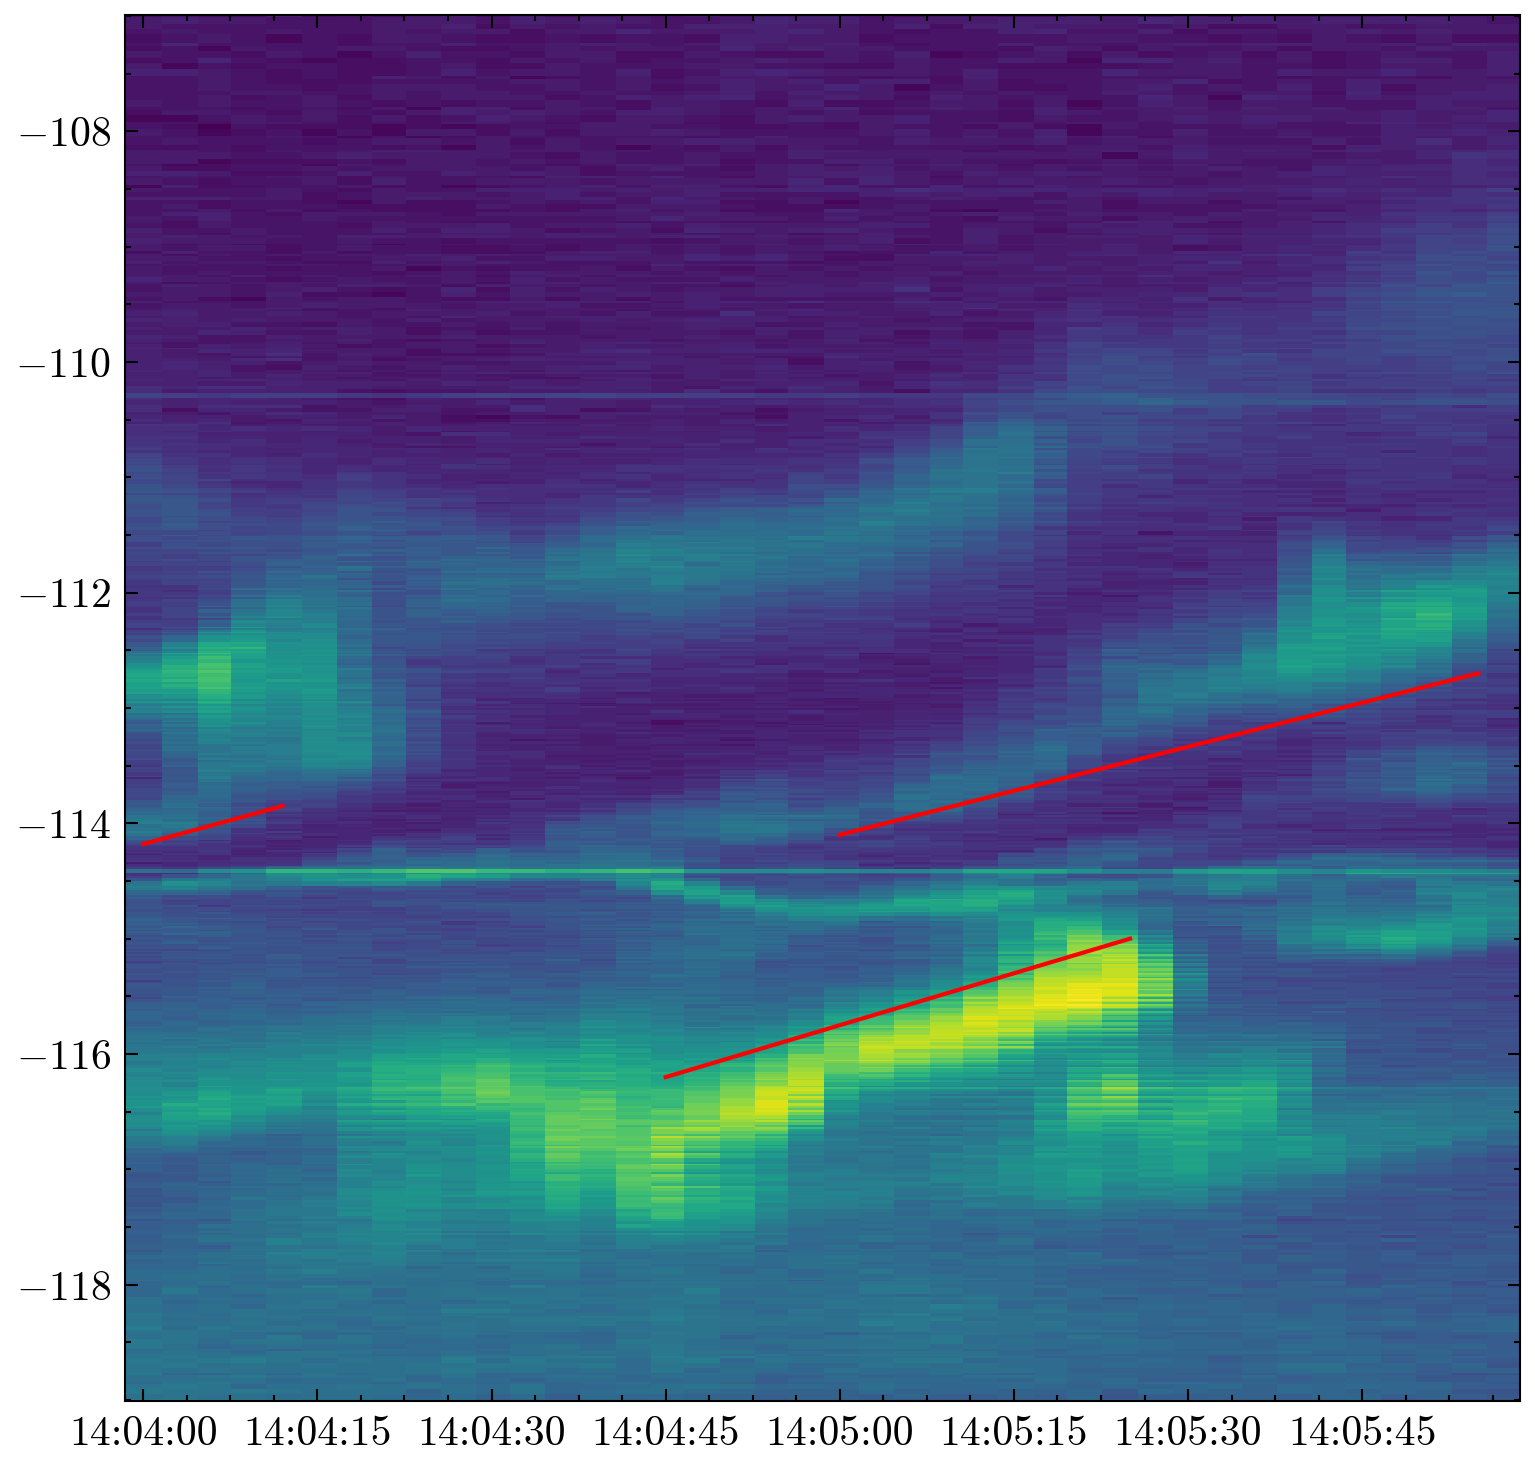

In [115]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_1, 1, 0 )[:,:,1])
#plt.contour(time_ewo, x_1,np.swapaxes(pixel_closest_1, 1, 0 )[:,:,1], 6, colors='k')
y = pd.date_range(start='2022-12-19 14:05:00', end='2022-12-19 14:05:55', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-114.1,-112.7, 100), color='red')
import geopy.distance
coords_1=(61.36, -114.1)
coords_2=(61.36, -112.7)
print(geopy.distance.geodesic(coords_1, coords_2).km)

print(geopy.distance.geodesic(coords_1, coords_2).km/(55))

y = pd.date_range(start='2022-12-19 14:04:0', end='2022-12-19 14:04:12', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-114.18,-113.85, 100), color='red')
import geopy.distance
coords_1=(61.36, -114.18)
coords_2=(61.36, -113.85)
print(geopy.distance.geodesic(coords_1, coords_2).km)

print(geopy.distance.geodesic(coords_1, coords_2).km/(12))

y = pd.date_range(start='2022-12-19 14:04:45', end='2022-12-19 14:05:25', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-116.2,-115, 100), color='red')
import geopy.distance
coords_1=(61.36, -116.2)
coords_2=(61.36, -115)
print(geopy.distance.geodesic(coords_1, coords_2).km)

print(geopy.distance.geodesic(coords_1, coords_2).km/(40))

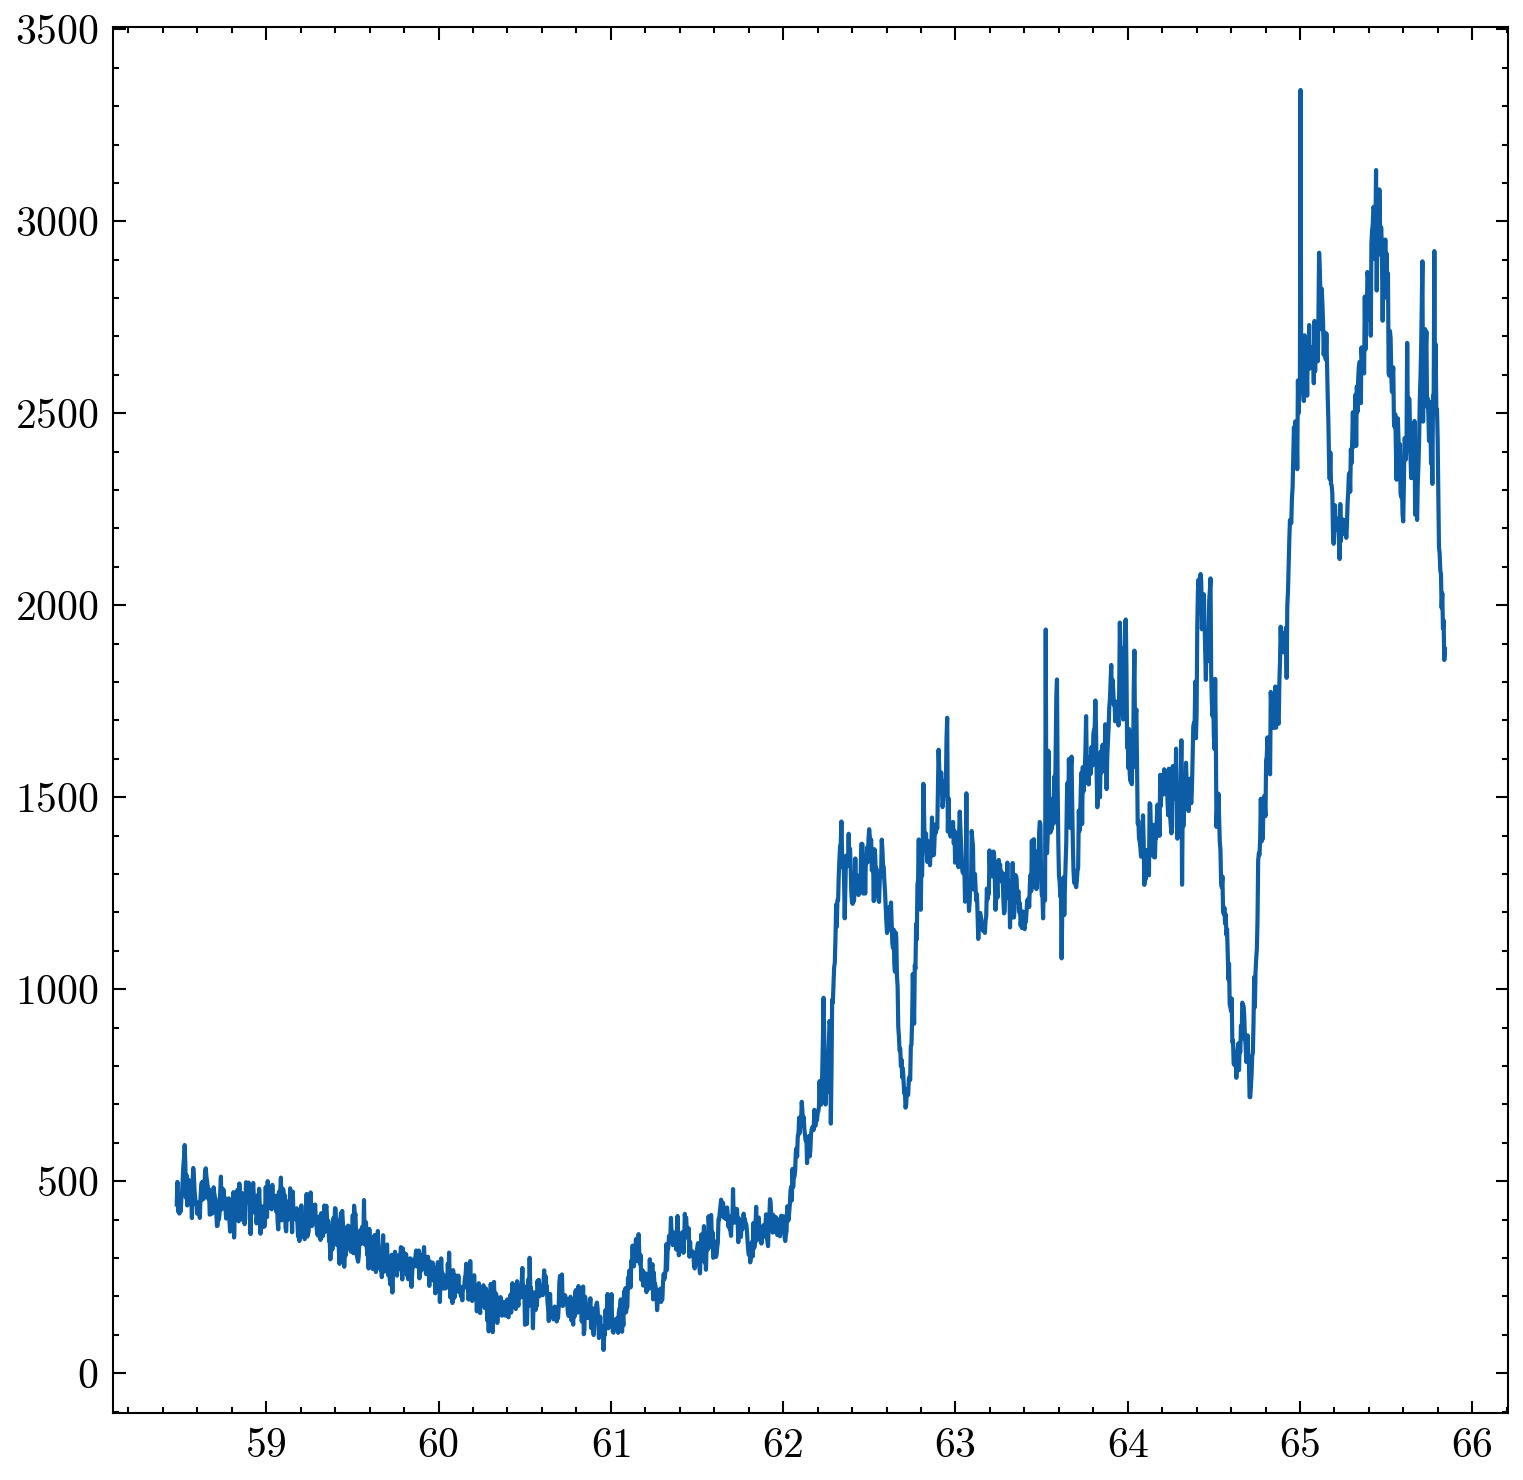

In [116]:
sat_lla_E[0]
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.plot(sat_lla_E[0], [np.sqrt(VNEC[x,0]**2+VNEC[x,1]**2+VNEC[x,2]**2) for x in range(len(VNEC))])

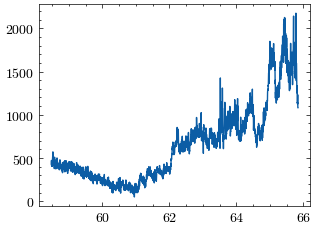

In [117]:
plt.plot(sat_lla_E[0], [np.sqrt(VNEC[x,0]**2) for x in range(len(VNEC))])

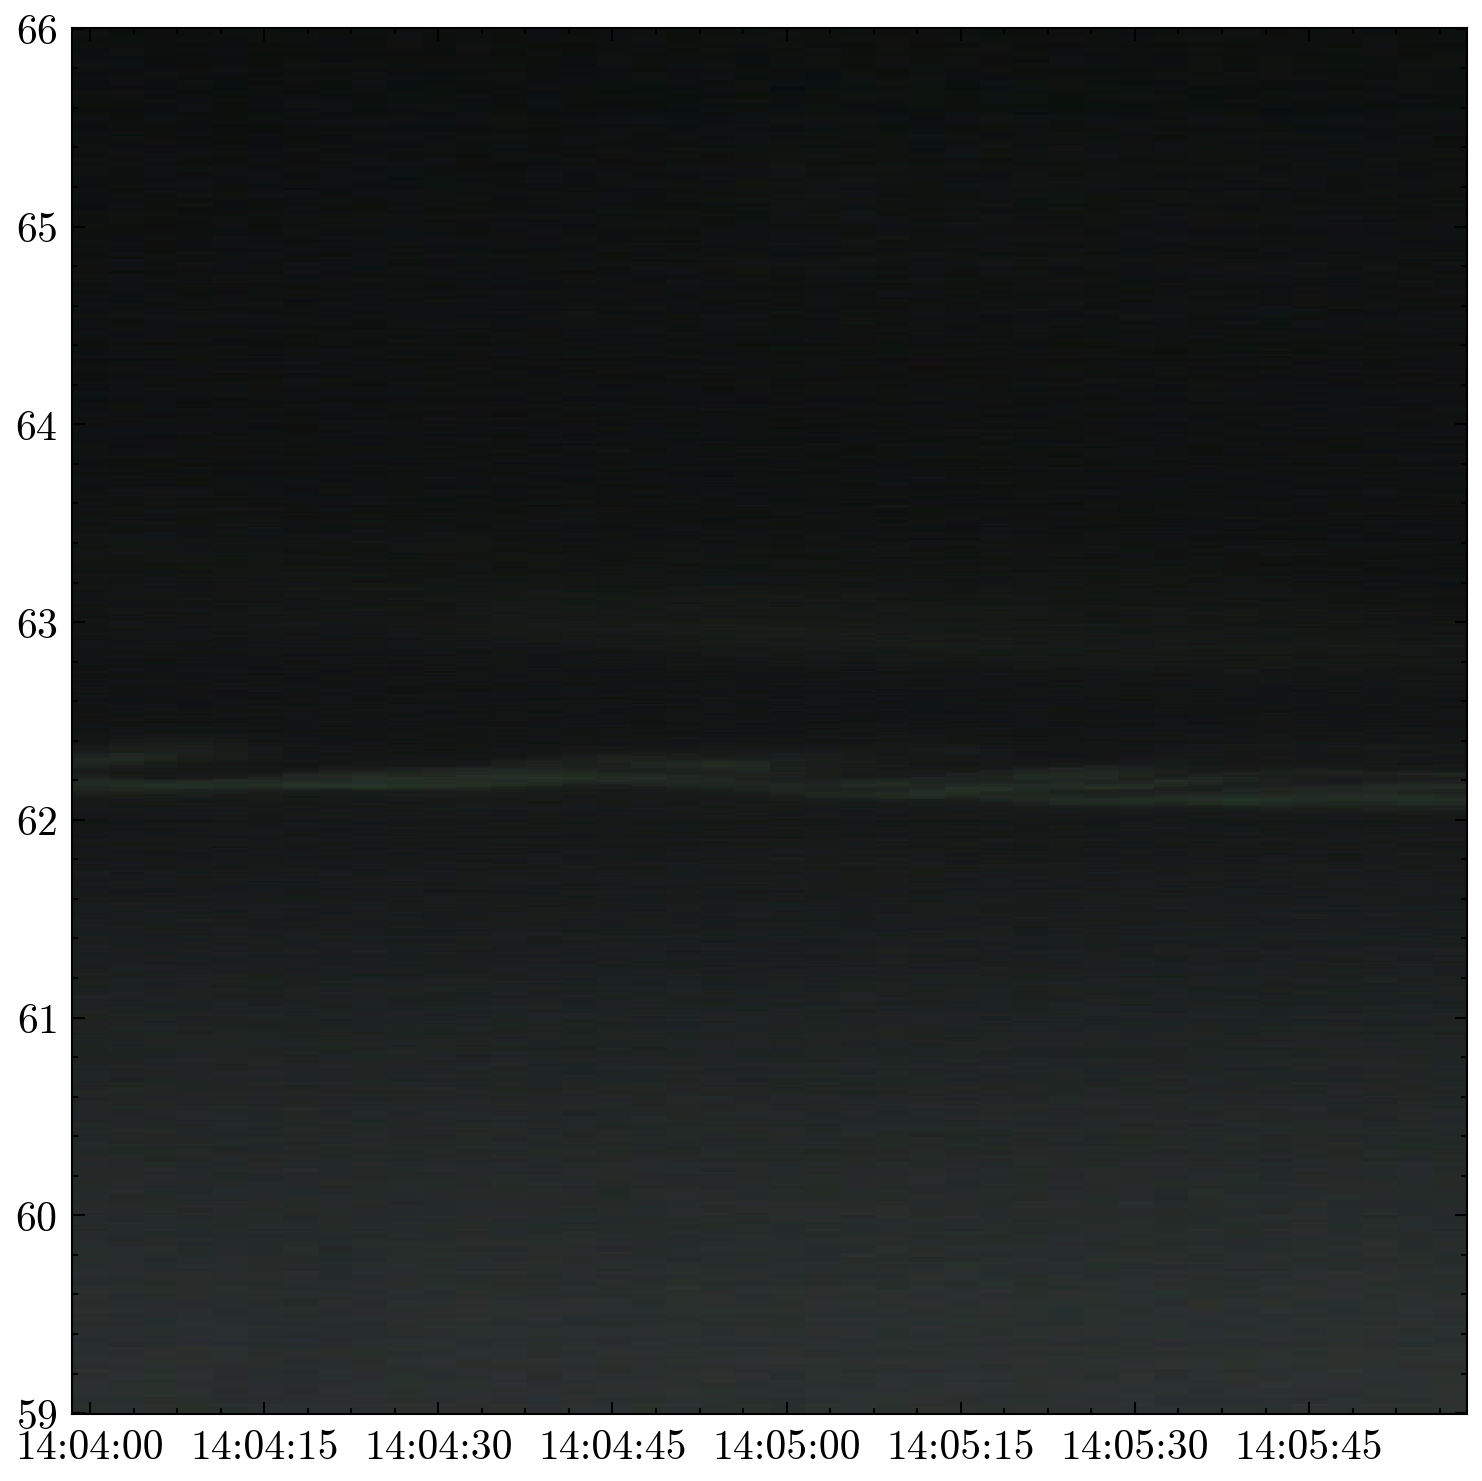

In [118]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolor( time_ewo, y_2,  np.swapaxes(pixel_closest_2, 1, 0))


TREX_RGB YKNF keogram: |################################################| 100%


(<Axes: title={'center': '2022-12-19 | TREX_RGB-YKNF keogram'}>,
 <matplotlib.collections.QuadMesh at 0x1484272d250>)

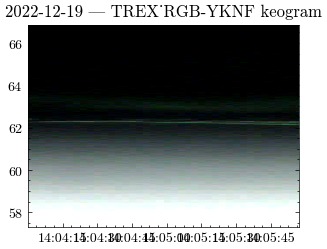

In [119]:
asi.plot_keogram()

(62.0, 64.0)

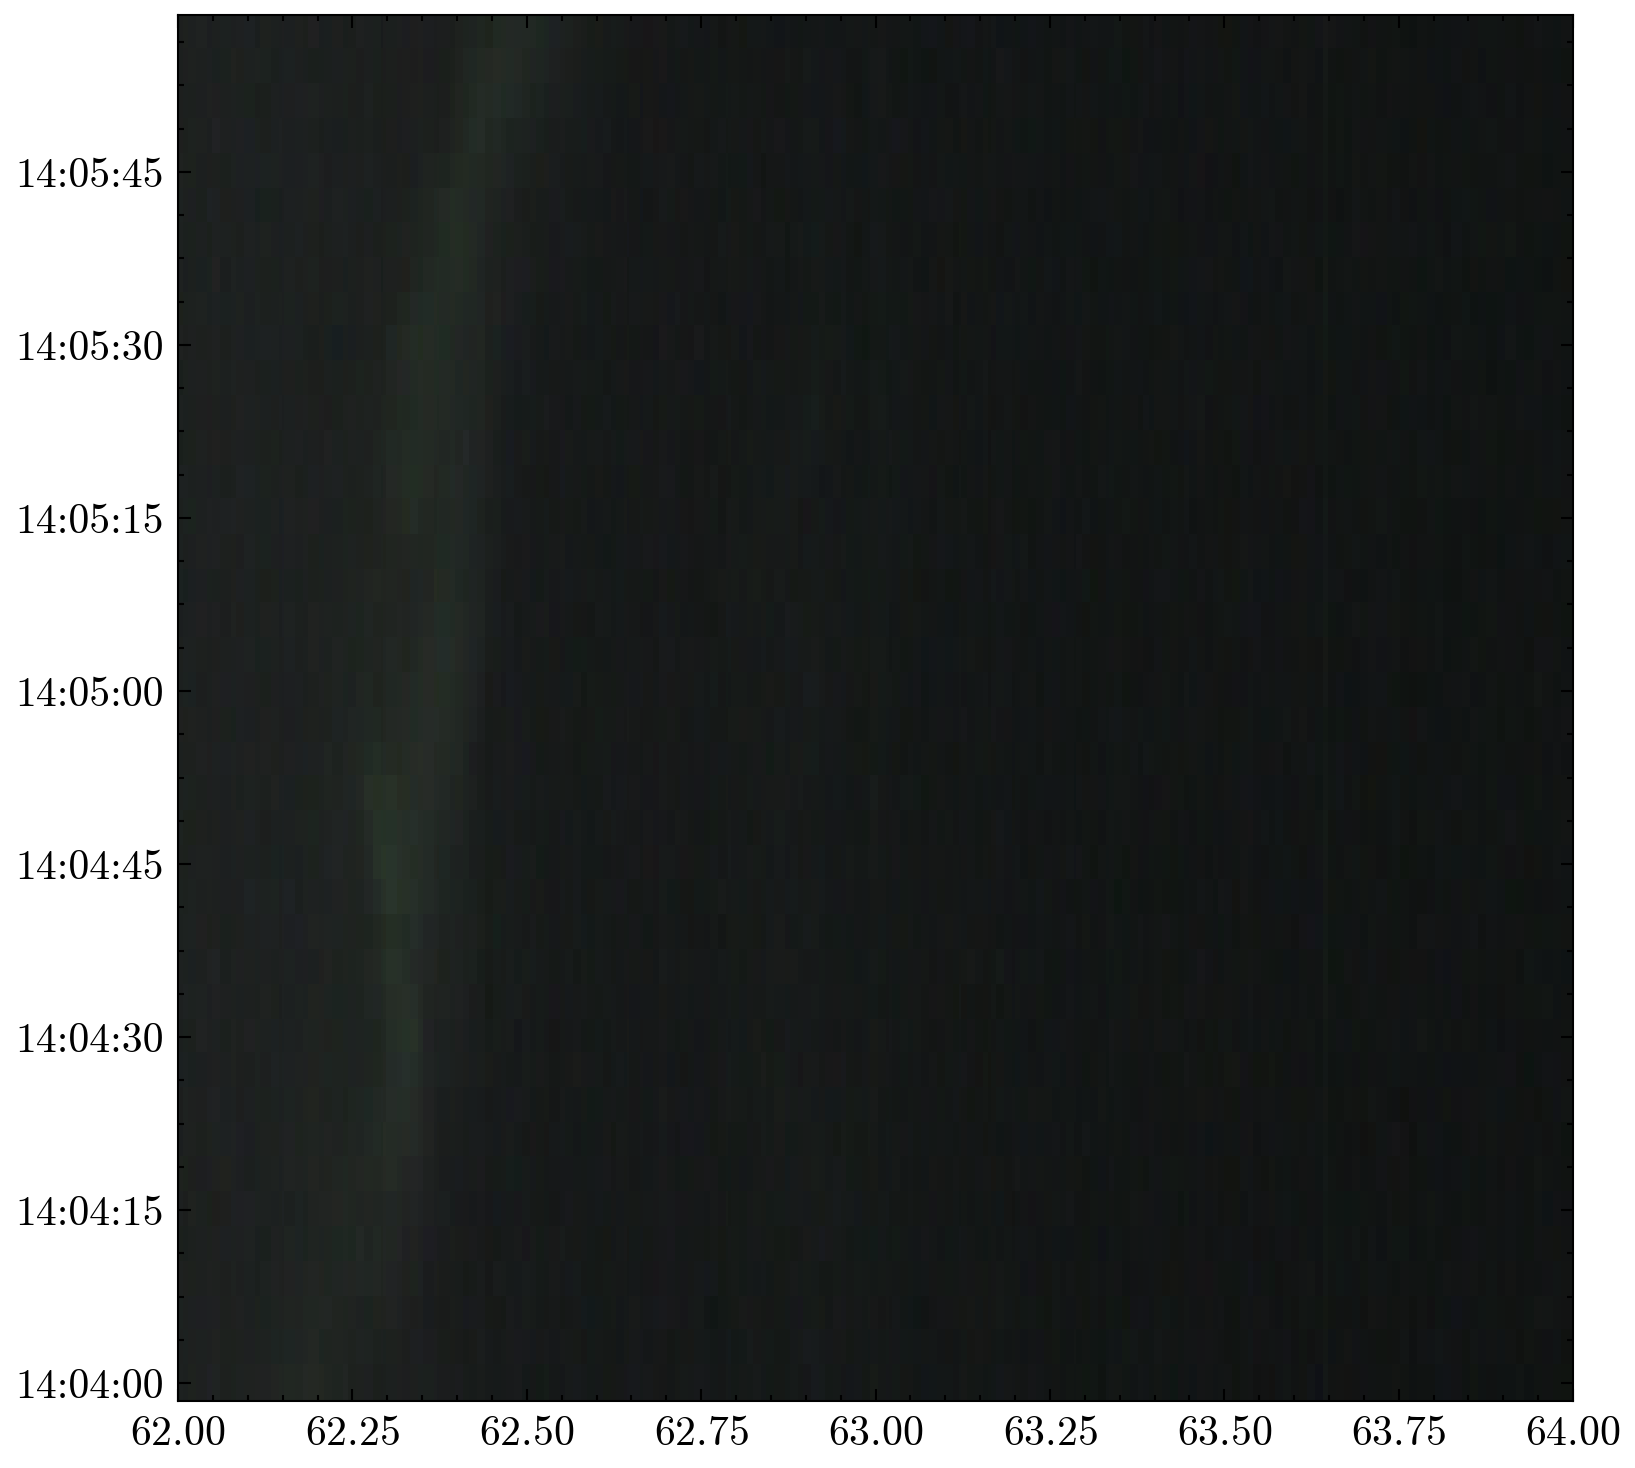

In [120]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolormesh( sat_lla_E[0], time_ewo,  np.reshape(pixel_closest_sat_track, (40,1920,3) ))
plt.xlim(62,64)

(40,)


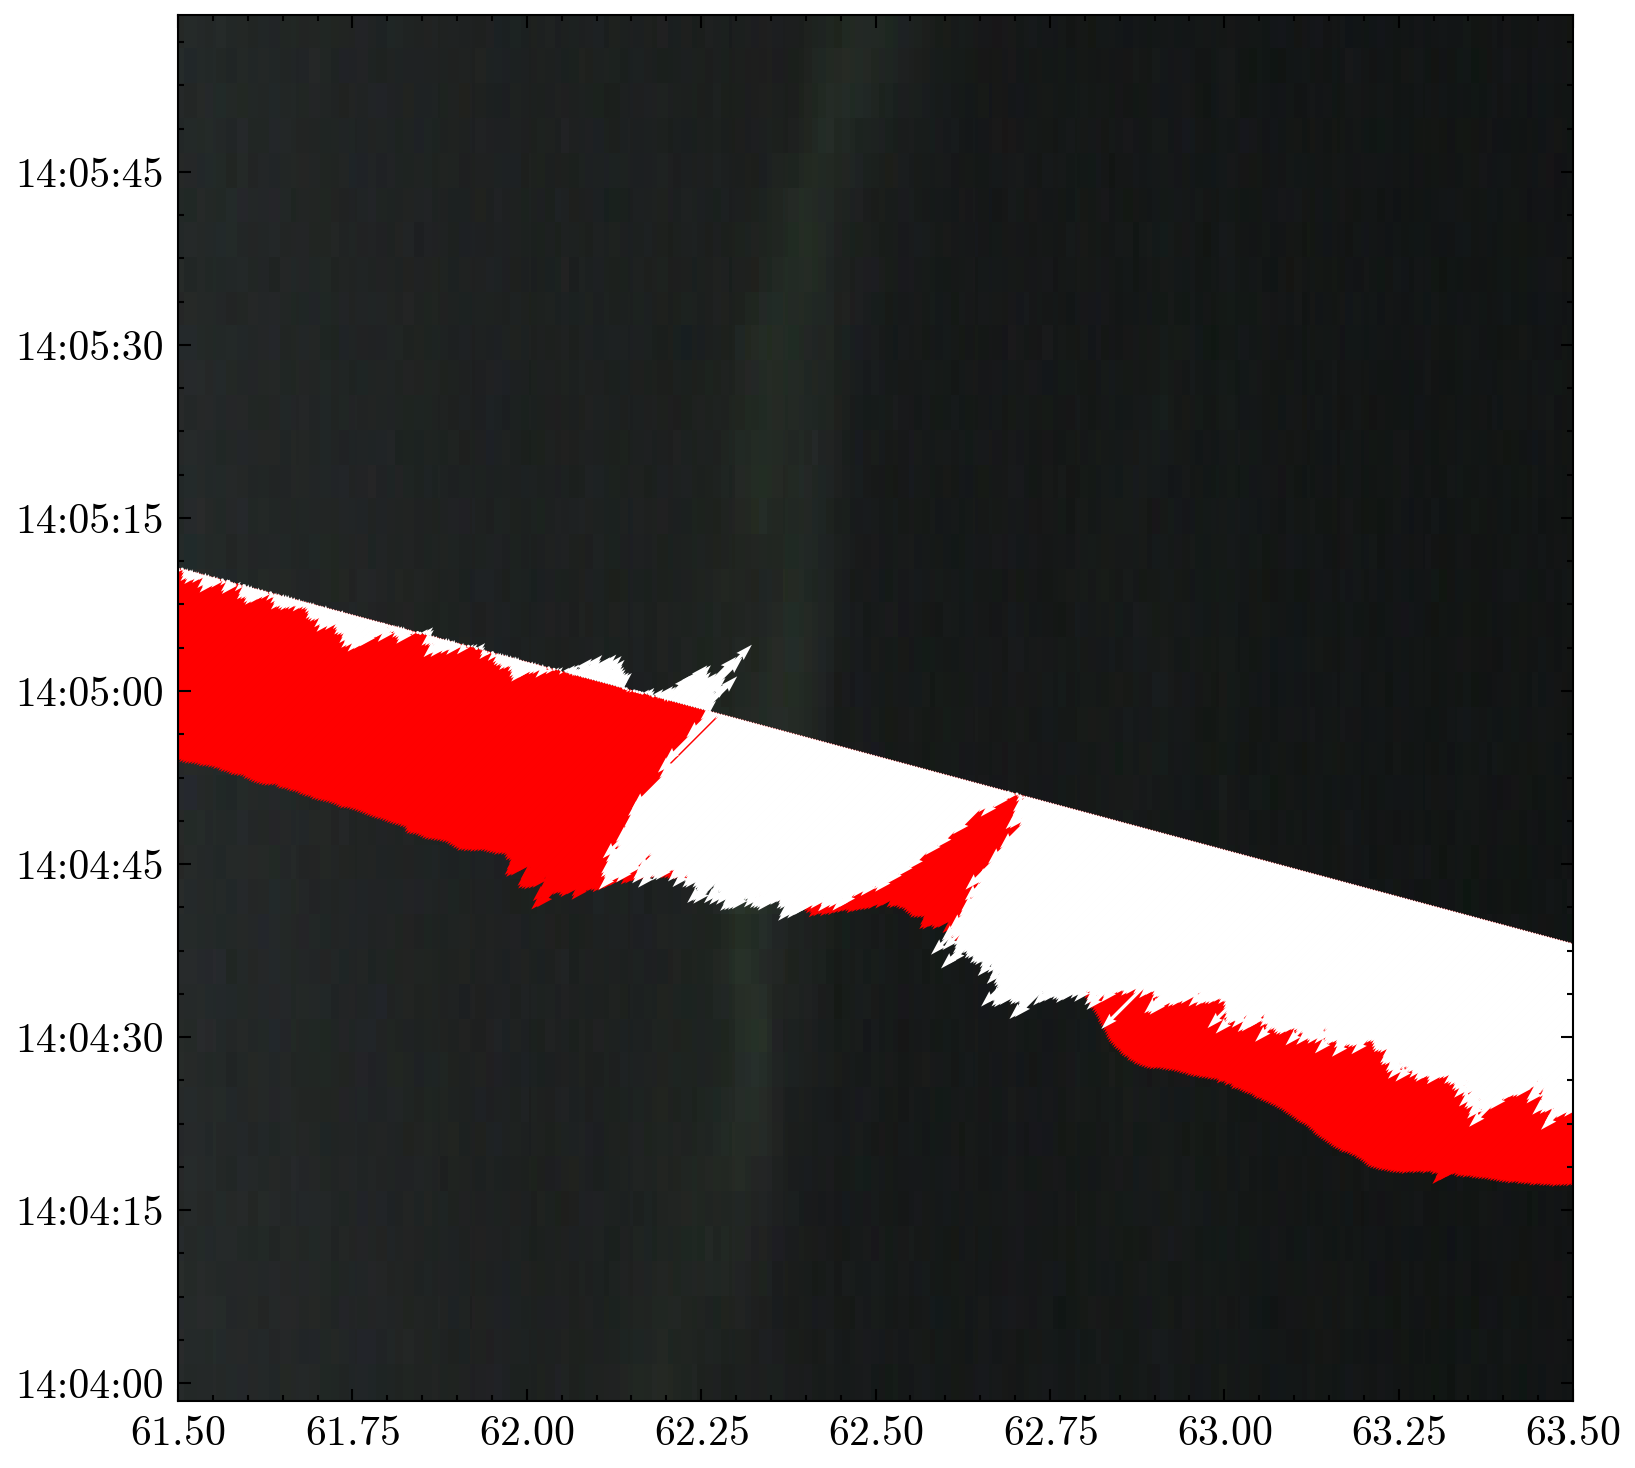

In [121]:
print(np.shape(time_ewo))
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolormesh( sat_lla_E[0],time_ewo,  np.reshape(pixel_closest_sat_track, (40,1920,3) ))
plt.xlim(61.5,63.5)


from scipy.interpolate import CubicSpline
cs = CubicSpline(Btime, sat_lla_B[0])
latitudes_16sps = cs(Etime)
cs = CubicSpline(Btime, BNEC[:,0])
Bs_16sps = cs(Etime)

plt.quiver(sat_lla_E[0], Etime, -Bs_16sps/np.max(np.abs(Bs_16sps)) , -Bs_16sps/np.max(np.abs(Bs_16sps)) , color='red', scale=1.2, scale_units='inches')

plt.quiver(sat_lla_E[0], Etime, ENEC[:,0]/np.max(np.abs(ENEC[:,0])), ENEC[:,0]/np.max(np.abs(ENEC[:,0])), color='white', scale=1, scale_units='inches')



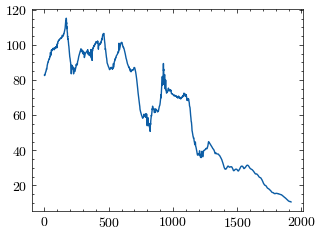

In [122]:
plt.plot( Bs_16sps)

[450 450 450 ... 250 250 250]
40
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800


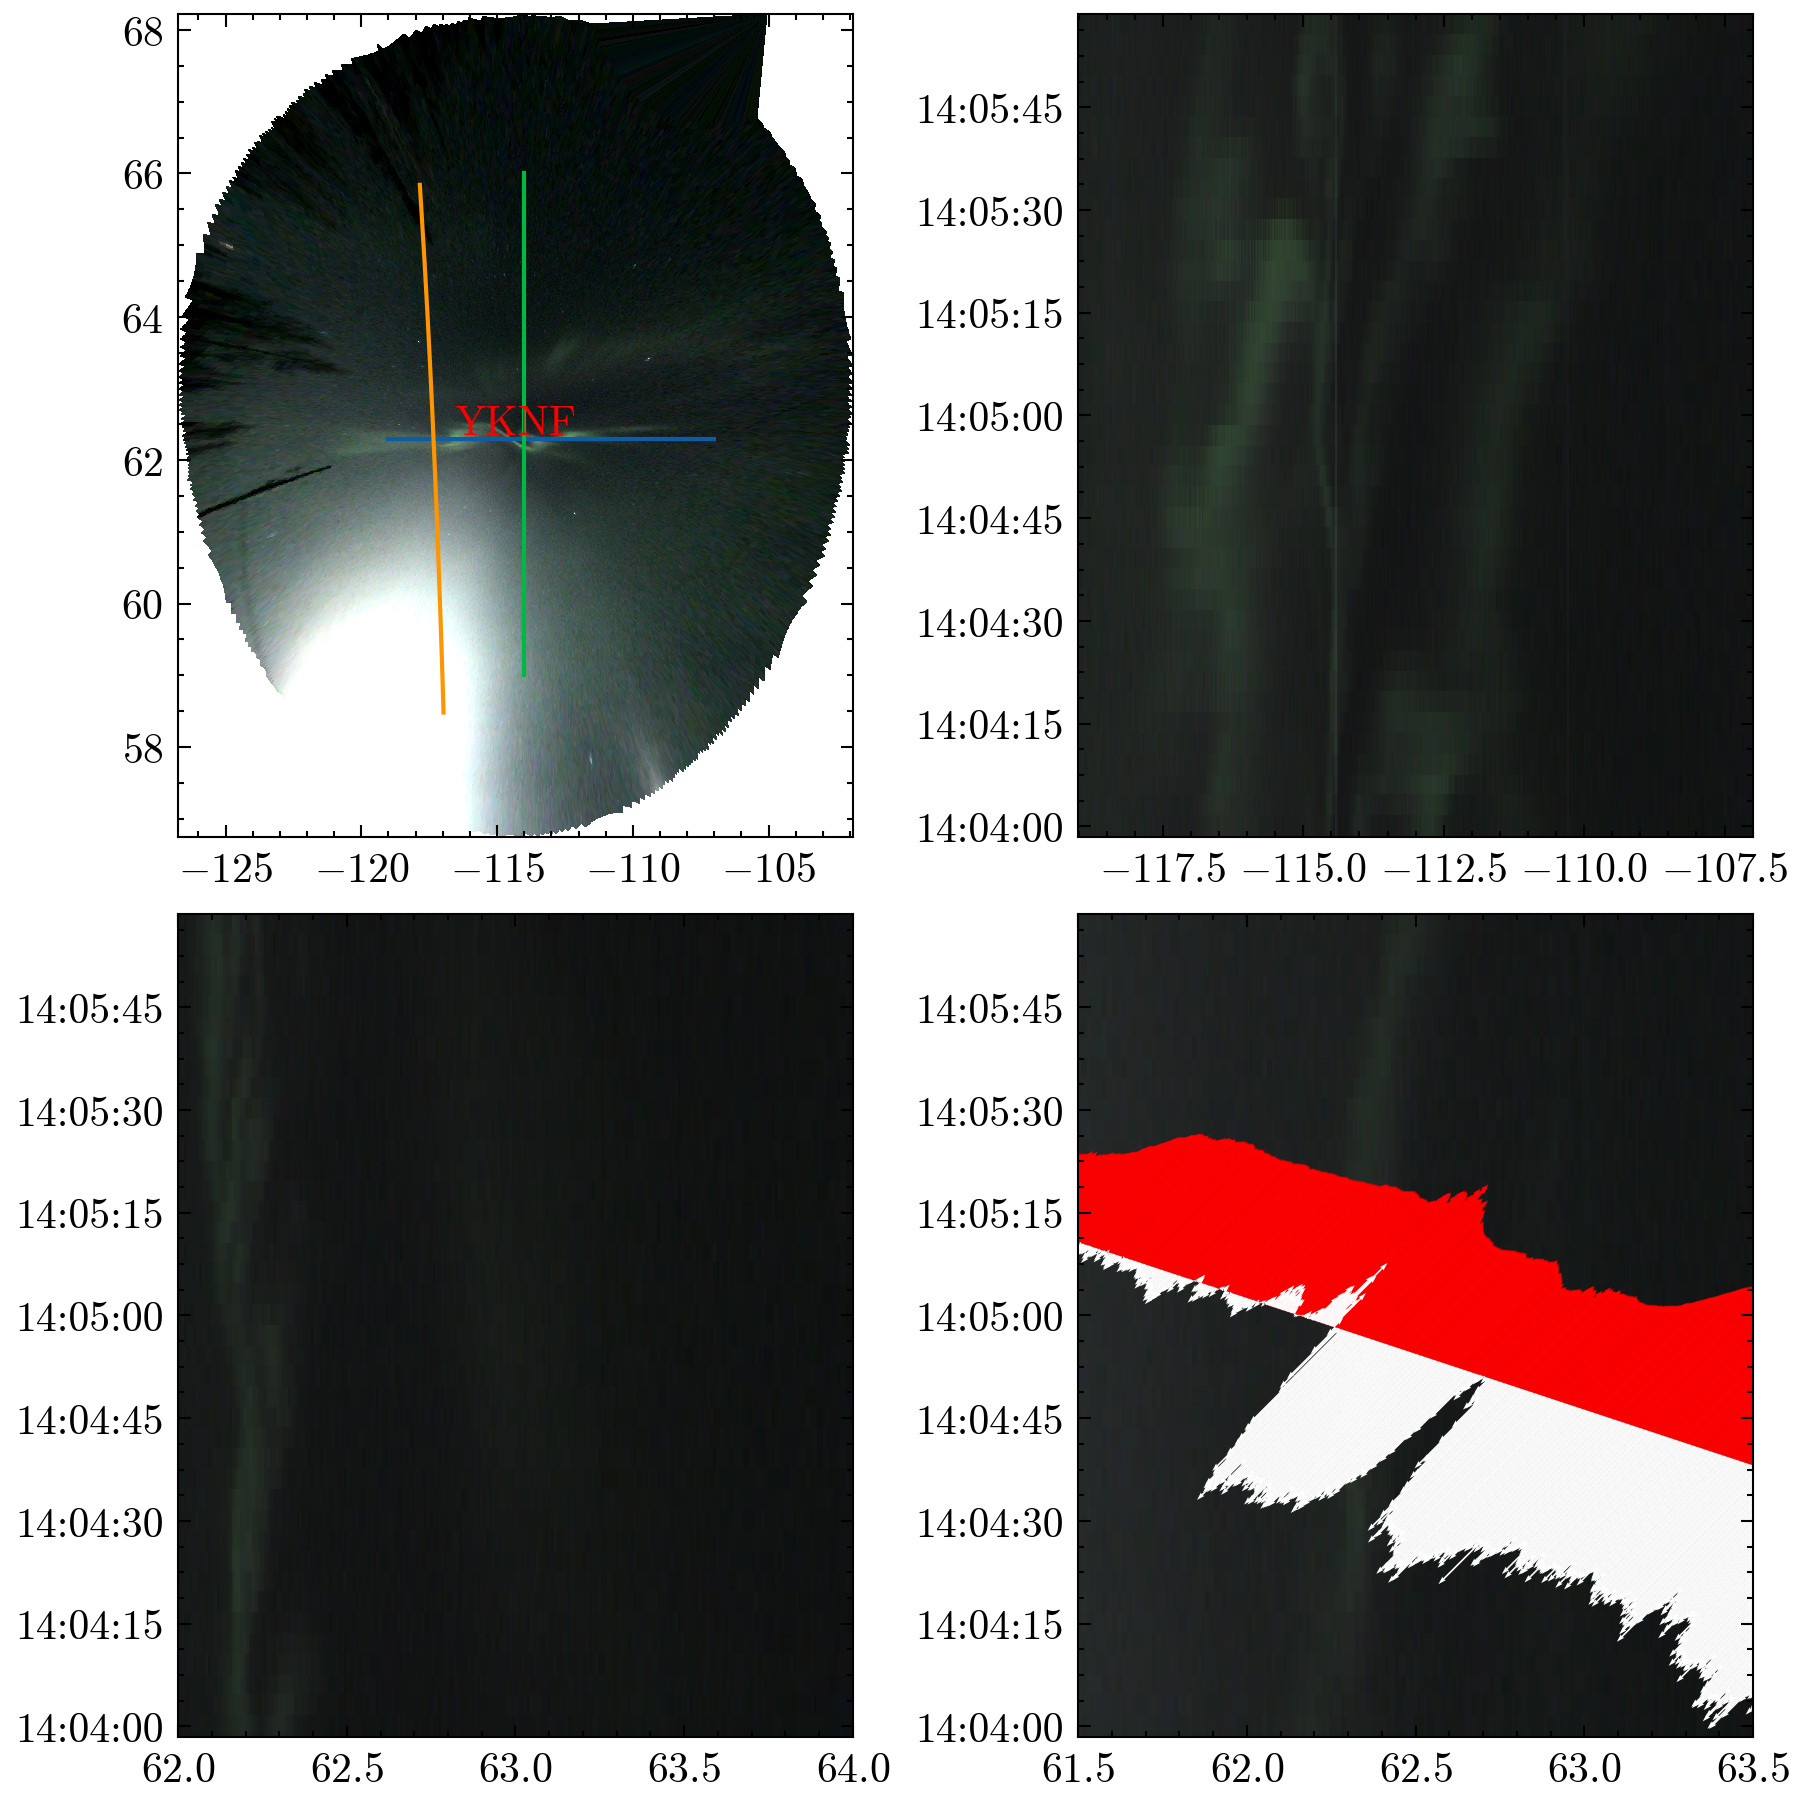

In [123]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300, nrows=2, ncols=2, constrained_layout=True) #show image of the track, and ewograms, then show the keograms of each line
axes, im_good = asi_single.plot_map(ax=ax[0][0])
print(closest_indices[:][1])



axes.plot(x_1,y_1)

axes.plot(x_2,y_2)
axes.plot(sat_lla_E[1], sat_lla_E[0]) #Ma
print(len(pixel_closest_1))

for i in range(len(pixel_closest_1)):
    print(len(pixel_closest_1[i]))


ax[0][1].pcolormesh(x_1, time_ewo,  np.reshape(pixel_closest_1, (40,800,3) ))

ax[1][0].pcolormesh(y_2, time_ewo,  np.reshape(pixel_closest_2, (40,800,3) ))
ax[1][0].set_xlim(62,64)

ax[1][1].pcolormesh( sat_lla_E[0],time_ewo,  np.reshape(pixel_closest_sat_track, (40,1920,3) ))
ax[1][1].set_xlim(61.5,63.5)

ax[1][1].quiver(sat_lla_E[0], Etime, Bs_16sps/np.max(np.abs(Bs_16sps)) , Bs_16sps/np.max(np.abs(Bs_16sps)) , color='red', scale=1.6, scale_units='inches')

ax[1][1].quiver(sat_lla_E[0], Etime, ENEC[:,0]/np.max(np.abs(ENEC[:,0])), ENEC[:,0]/np.max(np.abs(ENEC[:,0])), color='white', scale=1, scale_units='inches')


[18, 18, 18, 18, 18, 18, 18, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 8, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 18, 19, 17, 17, 17, 17, 17, 17, 20, 20, 20, 

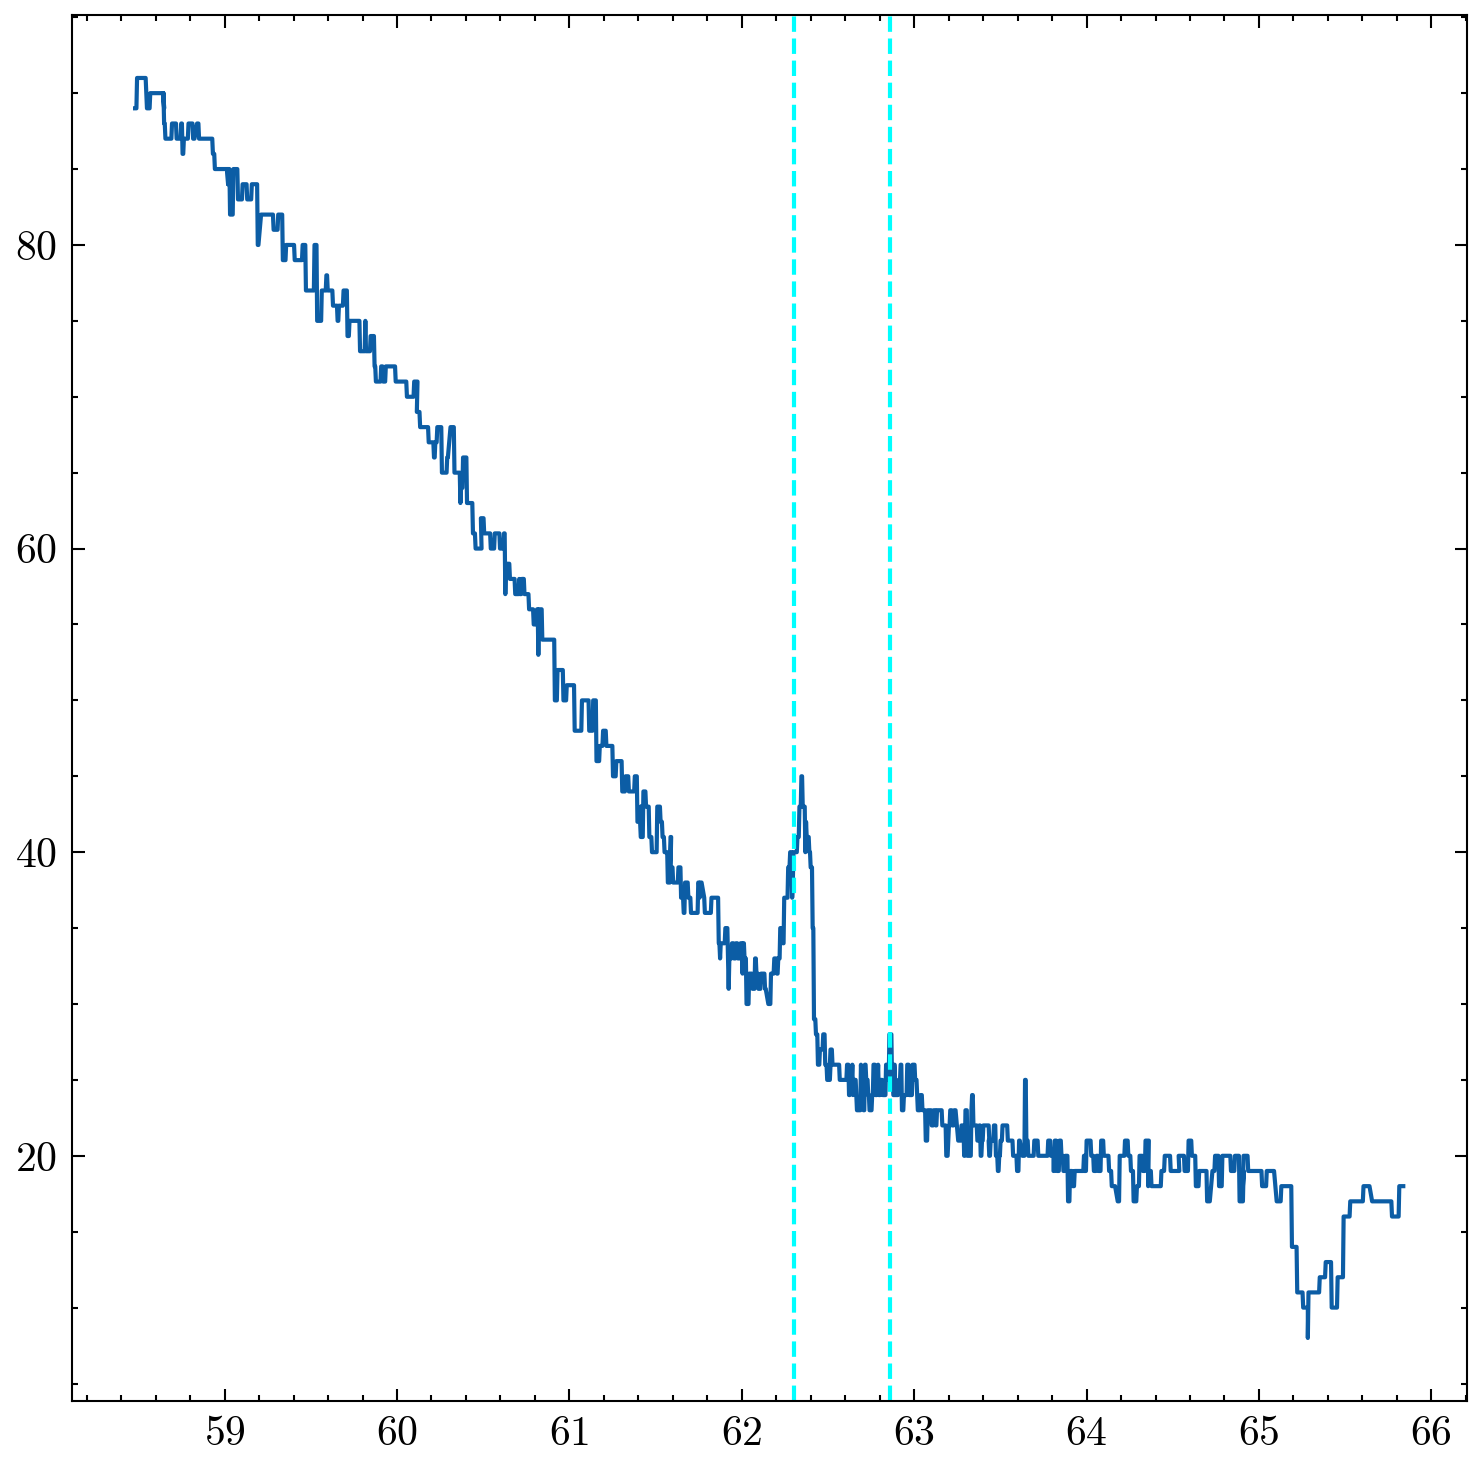

In [124]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
pixel_chosen_array= pixel_closest_sat
print(pixel_chosen_array)
plt.plot(lats, pixel_chosen_array)
plt.axvline(62.86, color='cyan', linestyle='dashed')
plt.axvline(62.3, color='cyan', linestyle='dashed')

Now lets make an ewogram

In [125]:
lat16 = sat_lla_E[0]
lat50 = sat_lla_B[0]

We want our plots to have lat verus data


(40, 3)



C:\Users\1101w\AppData\Local\Temp\ipykernel_8752\1558668660.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(61.0, 63.0)

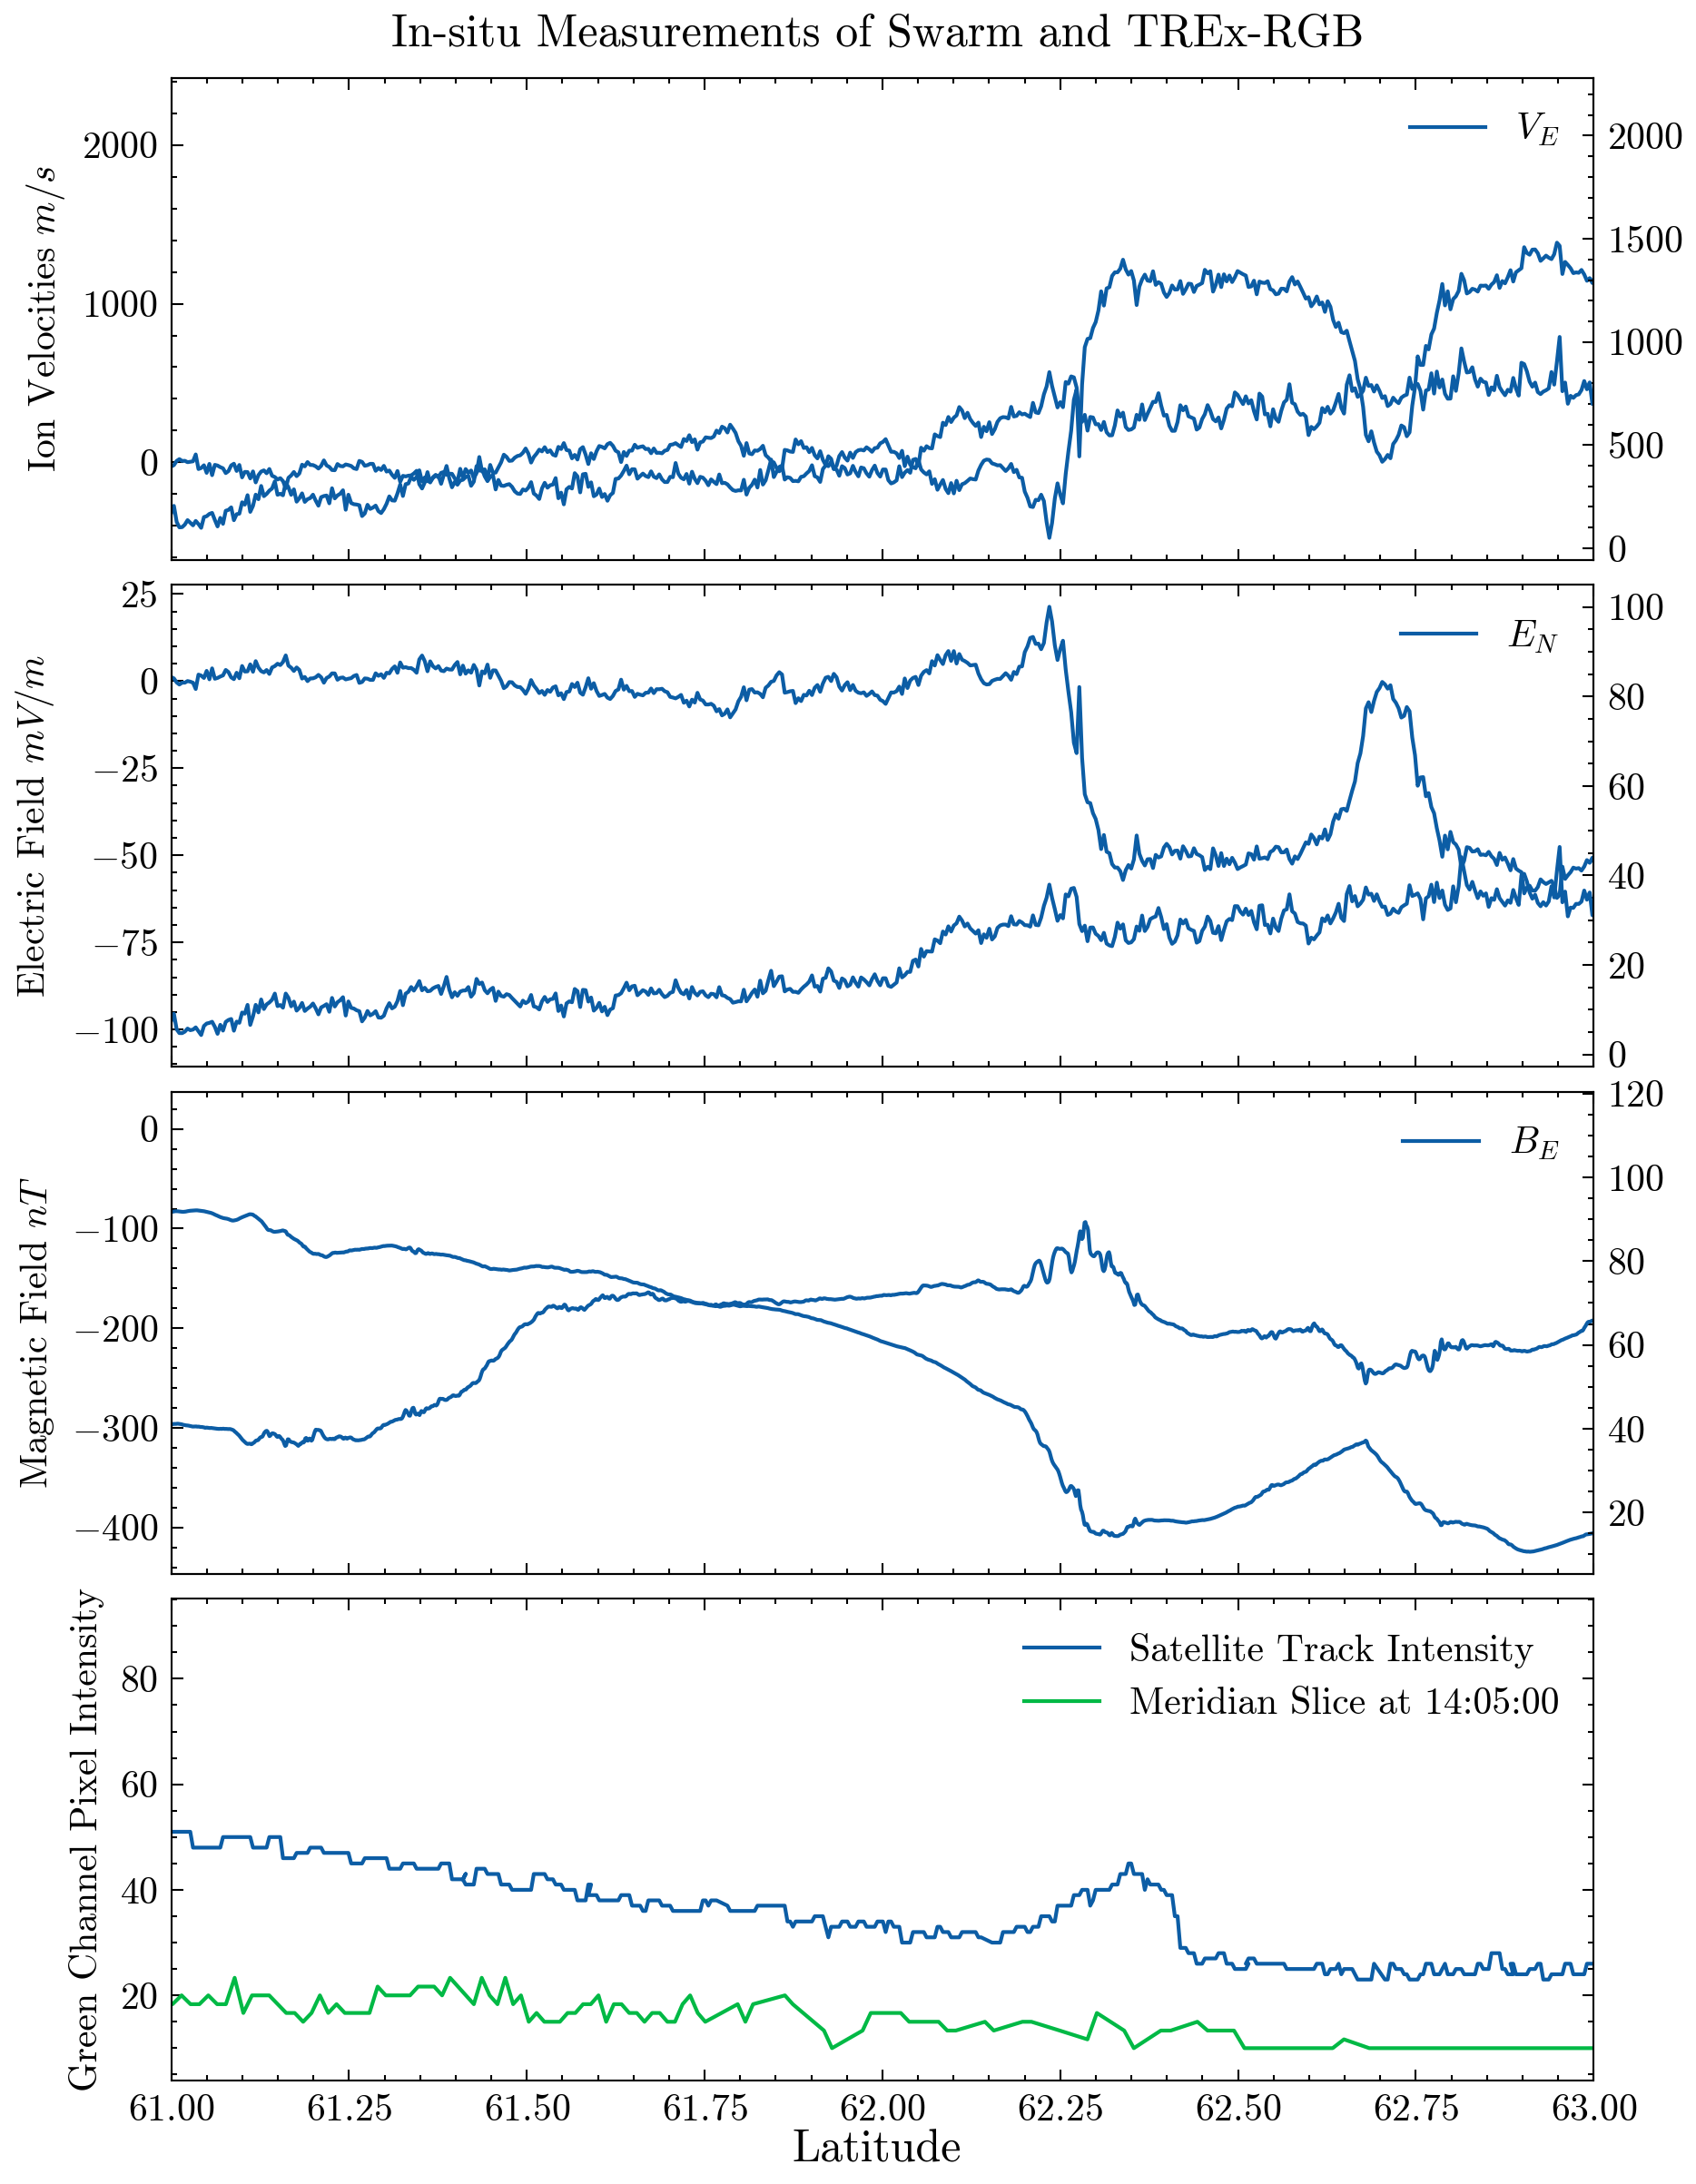

In [126]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")
Vtwin=axes[0].twinx()
Vtwin.plot(lat16,VNEC[:,0], label=r"$V_{N}$")

axes[1].plot(lat16, ENEC[:,0], label=r"$E_{N}$")
Etwin=axes[1].twinx()

Etwin.plot(lat16,ENEC[:,1], label=r"$E_{E}$")



Btwin=axes[2].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
print()
axes[3].plot(im_good.get_coordinates()[:, 60, 1][:-1], im_good.get_array()[:, 60, 0]*100+10, label="Meridian Slice at 14:05:00") #change colors



plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(61, 63)
axes[1].set_xlim(61, 63)
axes[2].set_xlim(61, 63)
axes[3].set_xlim(61, 63)

Doesn't line up because the arc doesnt follow magnetic latitude, its more aligned east west due to the convection flow shape

In [127]:
import numpy as np
import datetime

# Example array of Python datetime objects
datetime_array = np.array([
    datetime.datetime(2024, 8, 10, 12, 0),
    datetime.datetime(2024, 8, 11, 12, 0),
    datetime.datetime(2024, 8, 12, 12, 0),
    datetime.datetime(2024, 8, 13, 12, 0),
    datetime.datetime(2024, 8, 14, 12, 0)
])

# Given start and end datetimes
start_datetime = datetime.datetime(2024, 8, 11, 0, 0)
end_datetime = datetime.datetime(2024, 8, 13, 0, 0)

# Find the indices where datetime_array is between start_datetime and end_datetime
indices = np.where((datetime_array >= start_datetime) & (datetime_array <= end_datetime))[0]

print(indices)

[1 2]


Now we want to do a bandpass filter for the above electrodynamics data so we can differeinate between large and small scale. We will do a variety of filters so we can choose one that looks good. We will do 0.05Hz, 0.1Hz, 0.2Hz, 0.5Hz to 6Hz

In [128]:
from scipy.signal import butter, filtfilt

def butter_bandpass(cutoffs, fs, order=4):
    if cutoffs[0] ==0:
        return butter(order, cutoffs[1], fs=fs, btype="low")
    else:
        return butter(order, cutoffs, fs=fs, btype="band")


def butter_bandpass_filter(data, cutoffs, fs, order=4):
    b, a = butter_bandpass(cutoffs, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [129]:
V005,V01,V02,V05= np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC)))
E005,E01,E02,E05 = np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC)))
B005,B01,B02,B05 = np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC)))
for i in range(3):
    V005[:, i]=butter_bandpass_filter(VNEC[:, i], [0.05, 6], 16)
    V01[:, i]=butter_bandpass_filter(VNEC[:, i], [0.1, 6], 50)
    V02[:, i]=butter_bandpass_filter(VNEC[:, i], [0.2, 6], 50)
    V05[:, i]=butter_bandpass_filter(VNEC[:, i], [0.5, 6], 50)

    E005[:, i]=butter_bandpass_filter(ENEC[:, i], [0.05, 6], 16)
    E01[:, i]=butter_bandpass_filter(ENEC[:, i], [0.1, 6], 16)
    E02[:, i]=butter_bandpass_filter(ENEC[:, i], [0.2, 6], 16)
    E05[:, i]=butter_bandpass_filter(ENEC[:, i], [0.5, 6], 16)


    B005[:, i]=butter_bandpass_filter(BNEC[:, i], [0.05, 6], 50)
    B01[:, i]=butter_bandpass_filter(BNEC[:, i], [0.1, 6], 50)
    B02[:, i]=butter_bandpass_filter(BNEC[:, i], [0.2, 6], 50)
    B05[:, i]=butter_bandpass_filter(BNEC[:, i], [0.5, 6], 50)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_8752\517856379.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

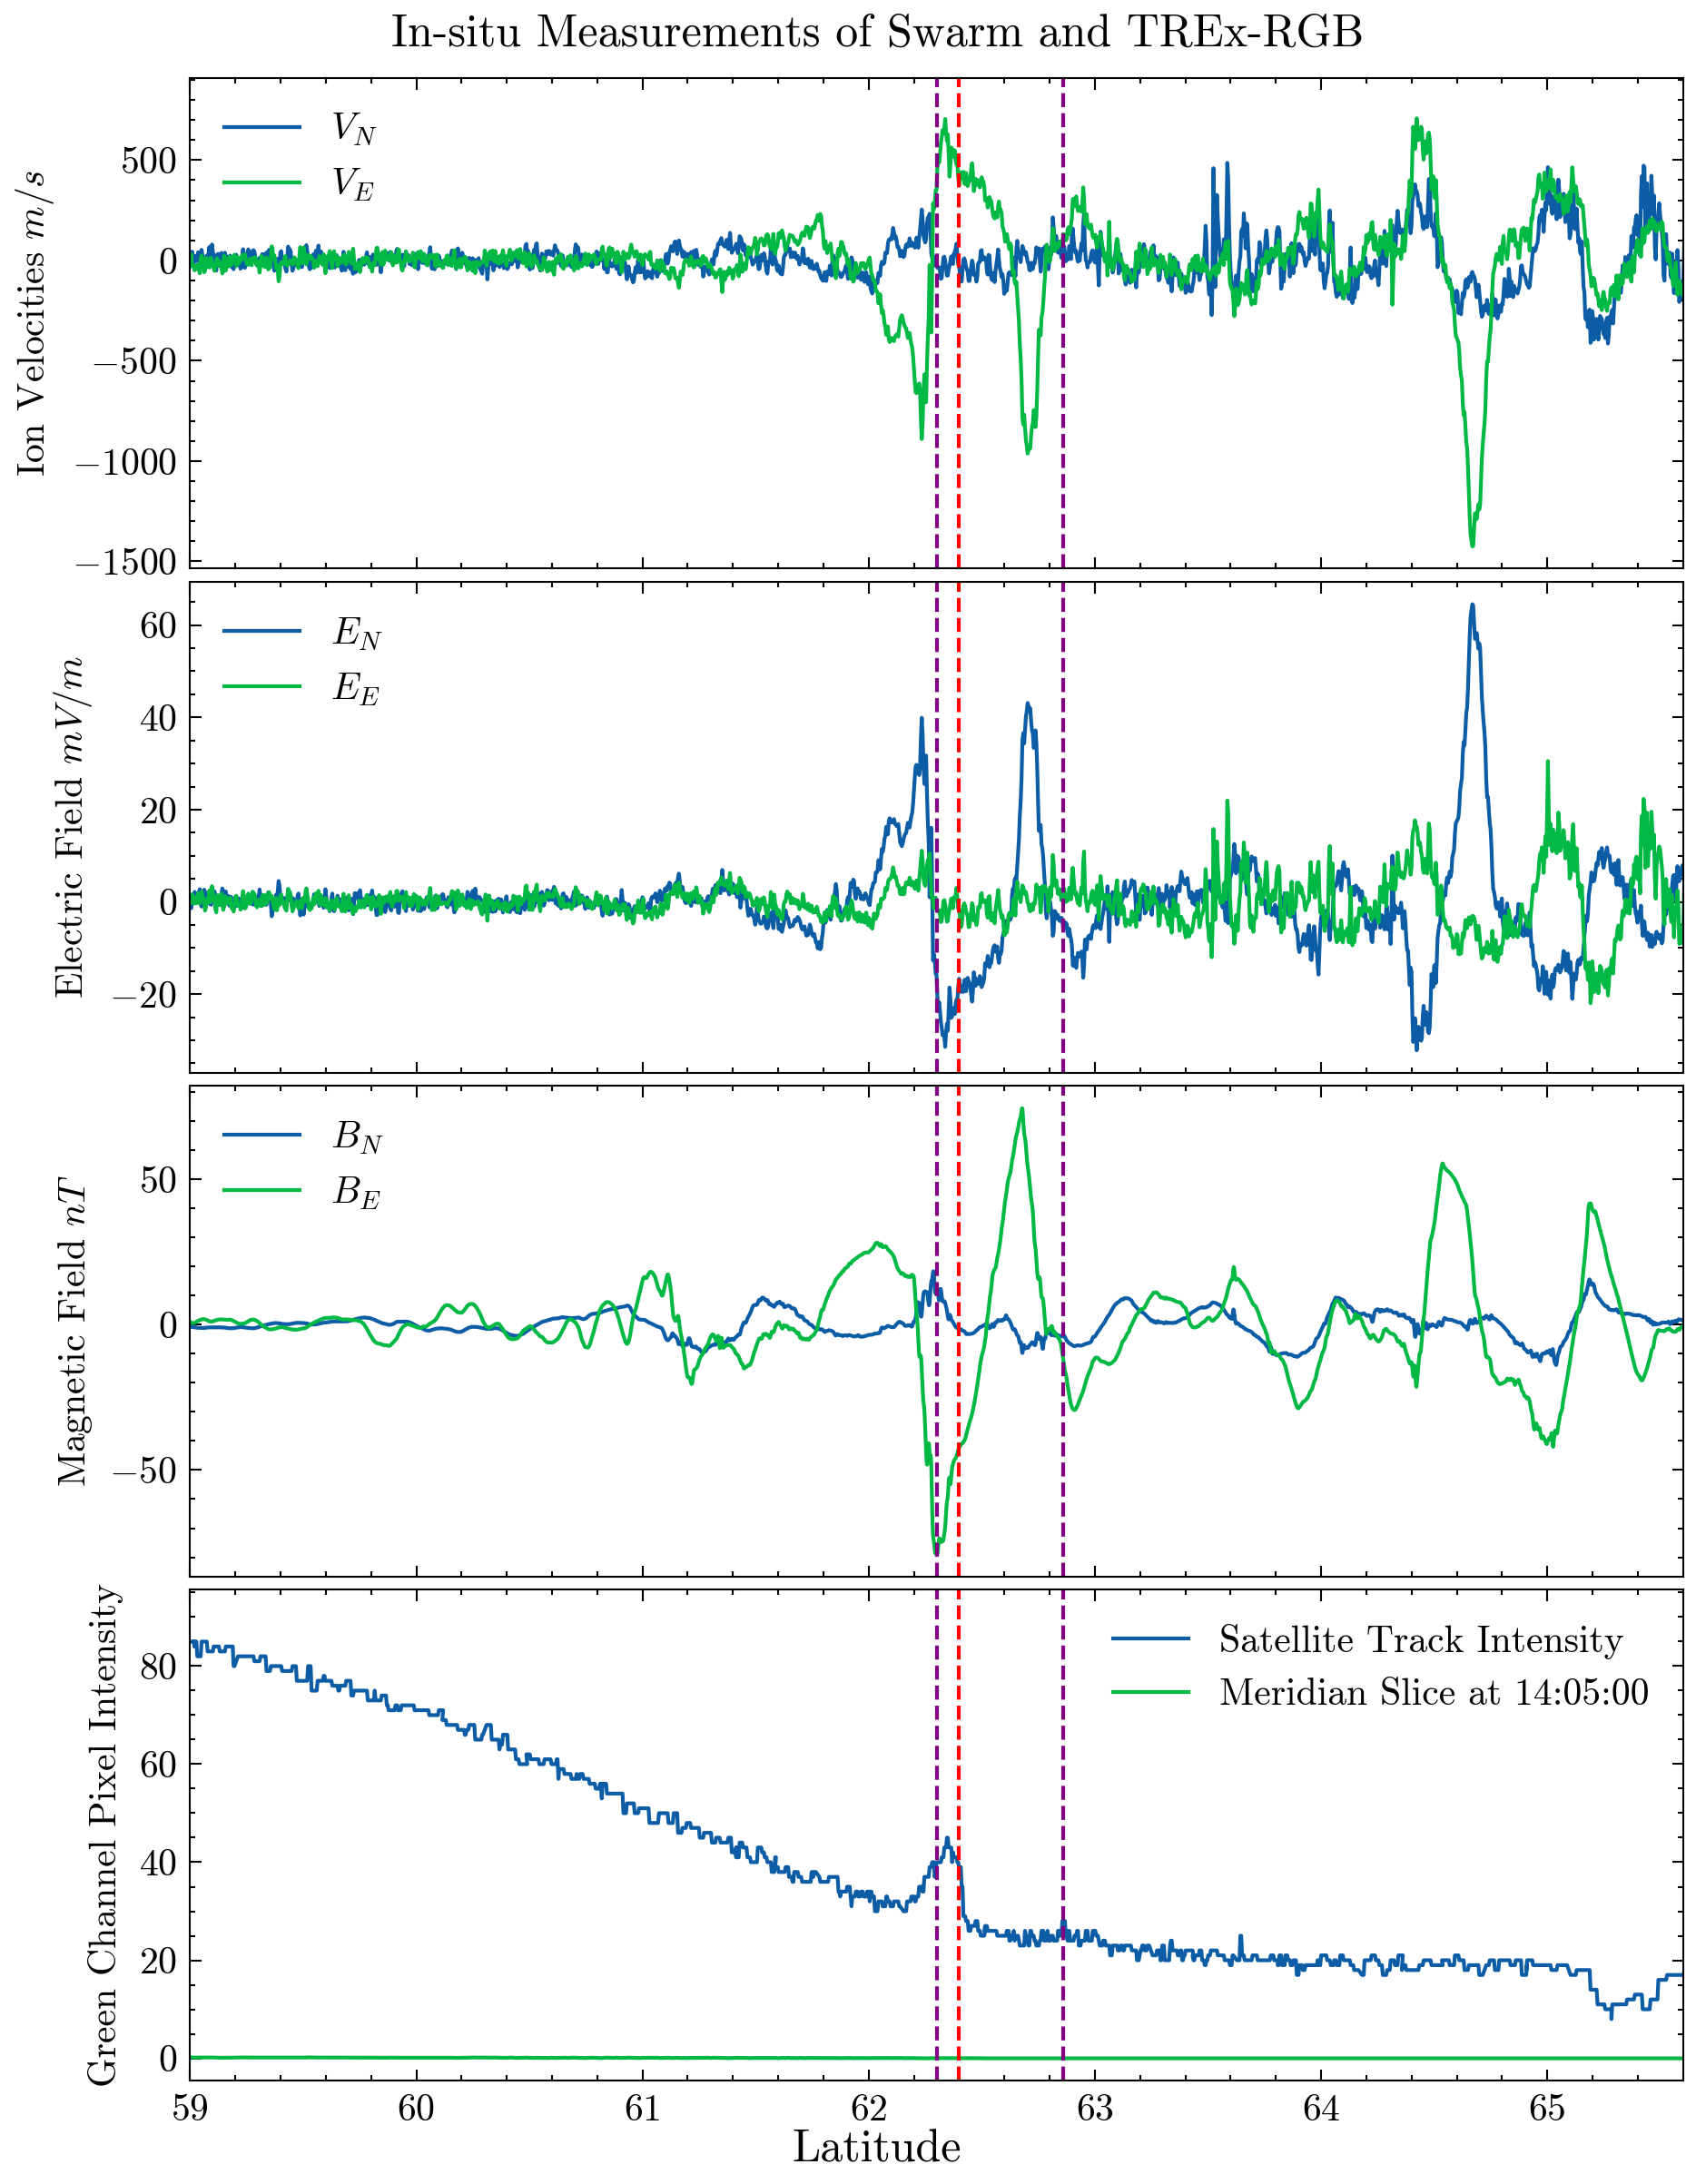

In [130]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V005[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V005[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E005[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E005[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B005[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B005[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_8752\3546714463.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

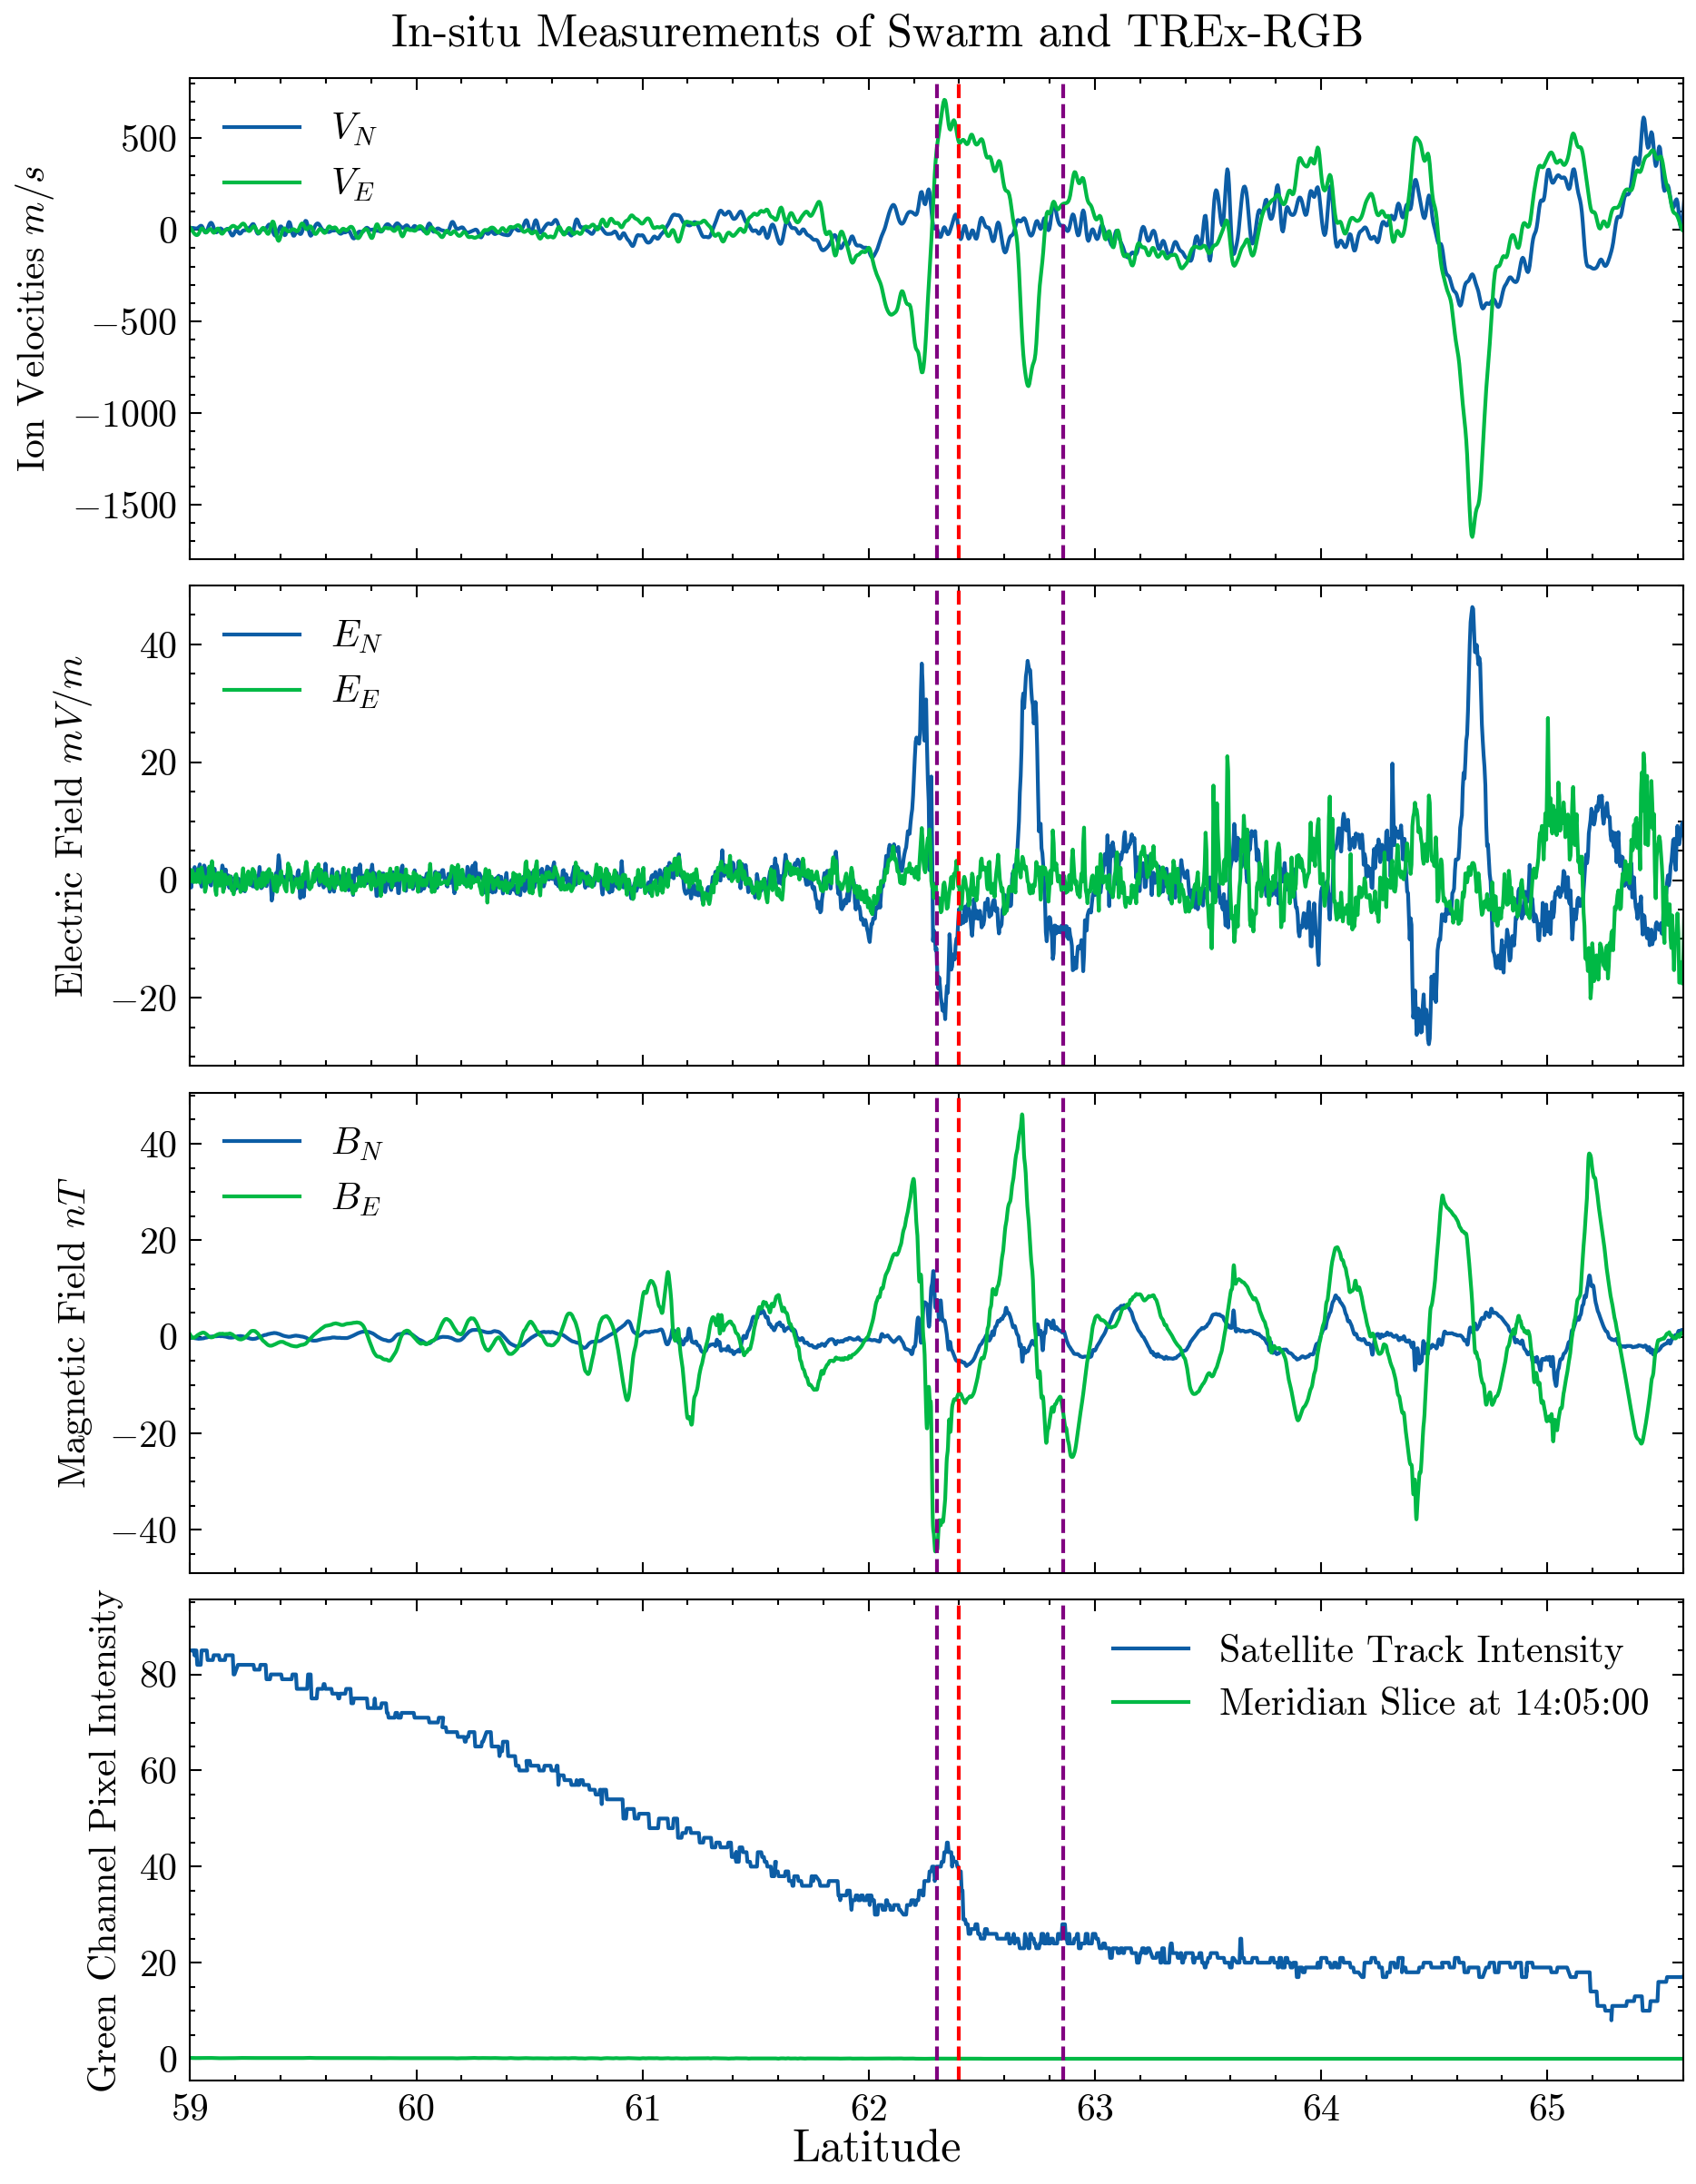

In [131]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V01[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V01[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E01[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E01[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B01[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B01[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_8752\2505789916.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

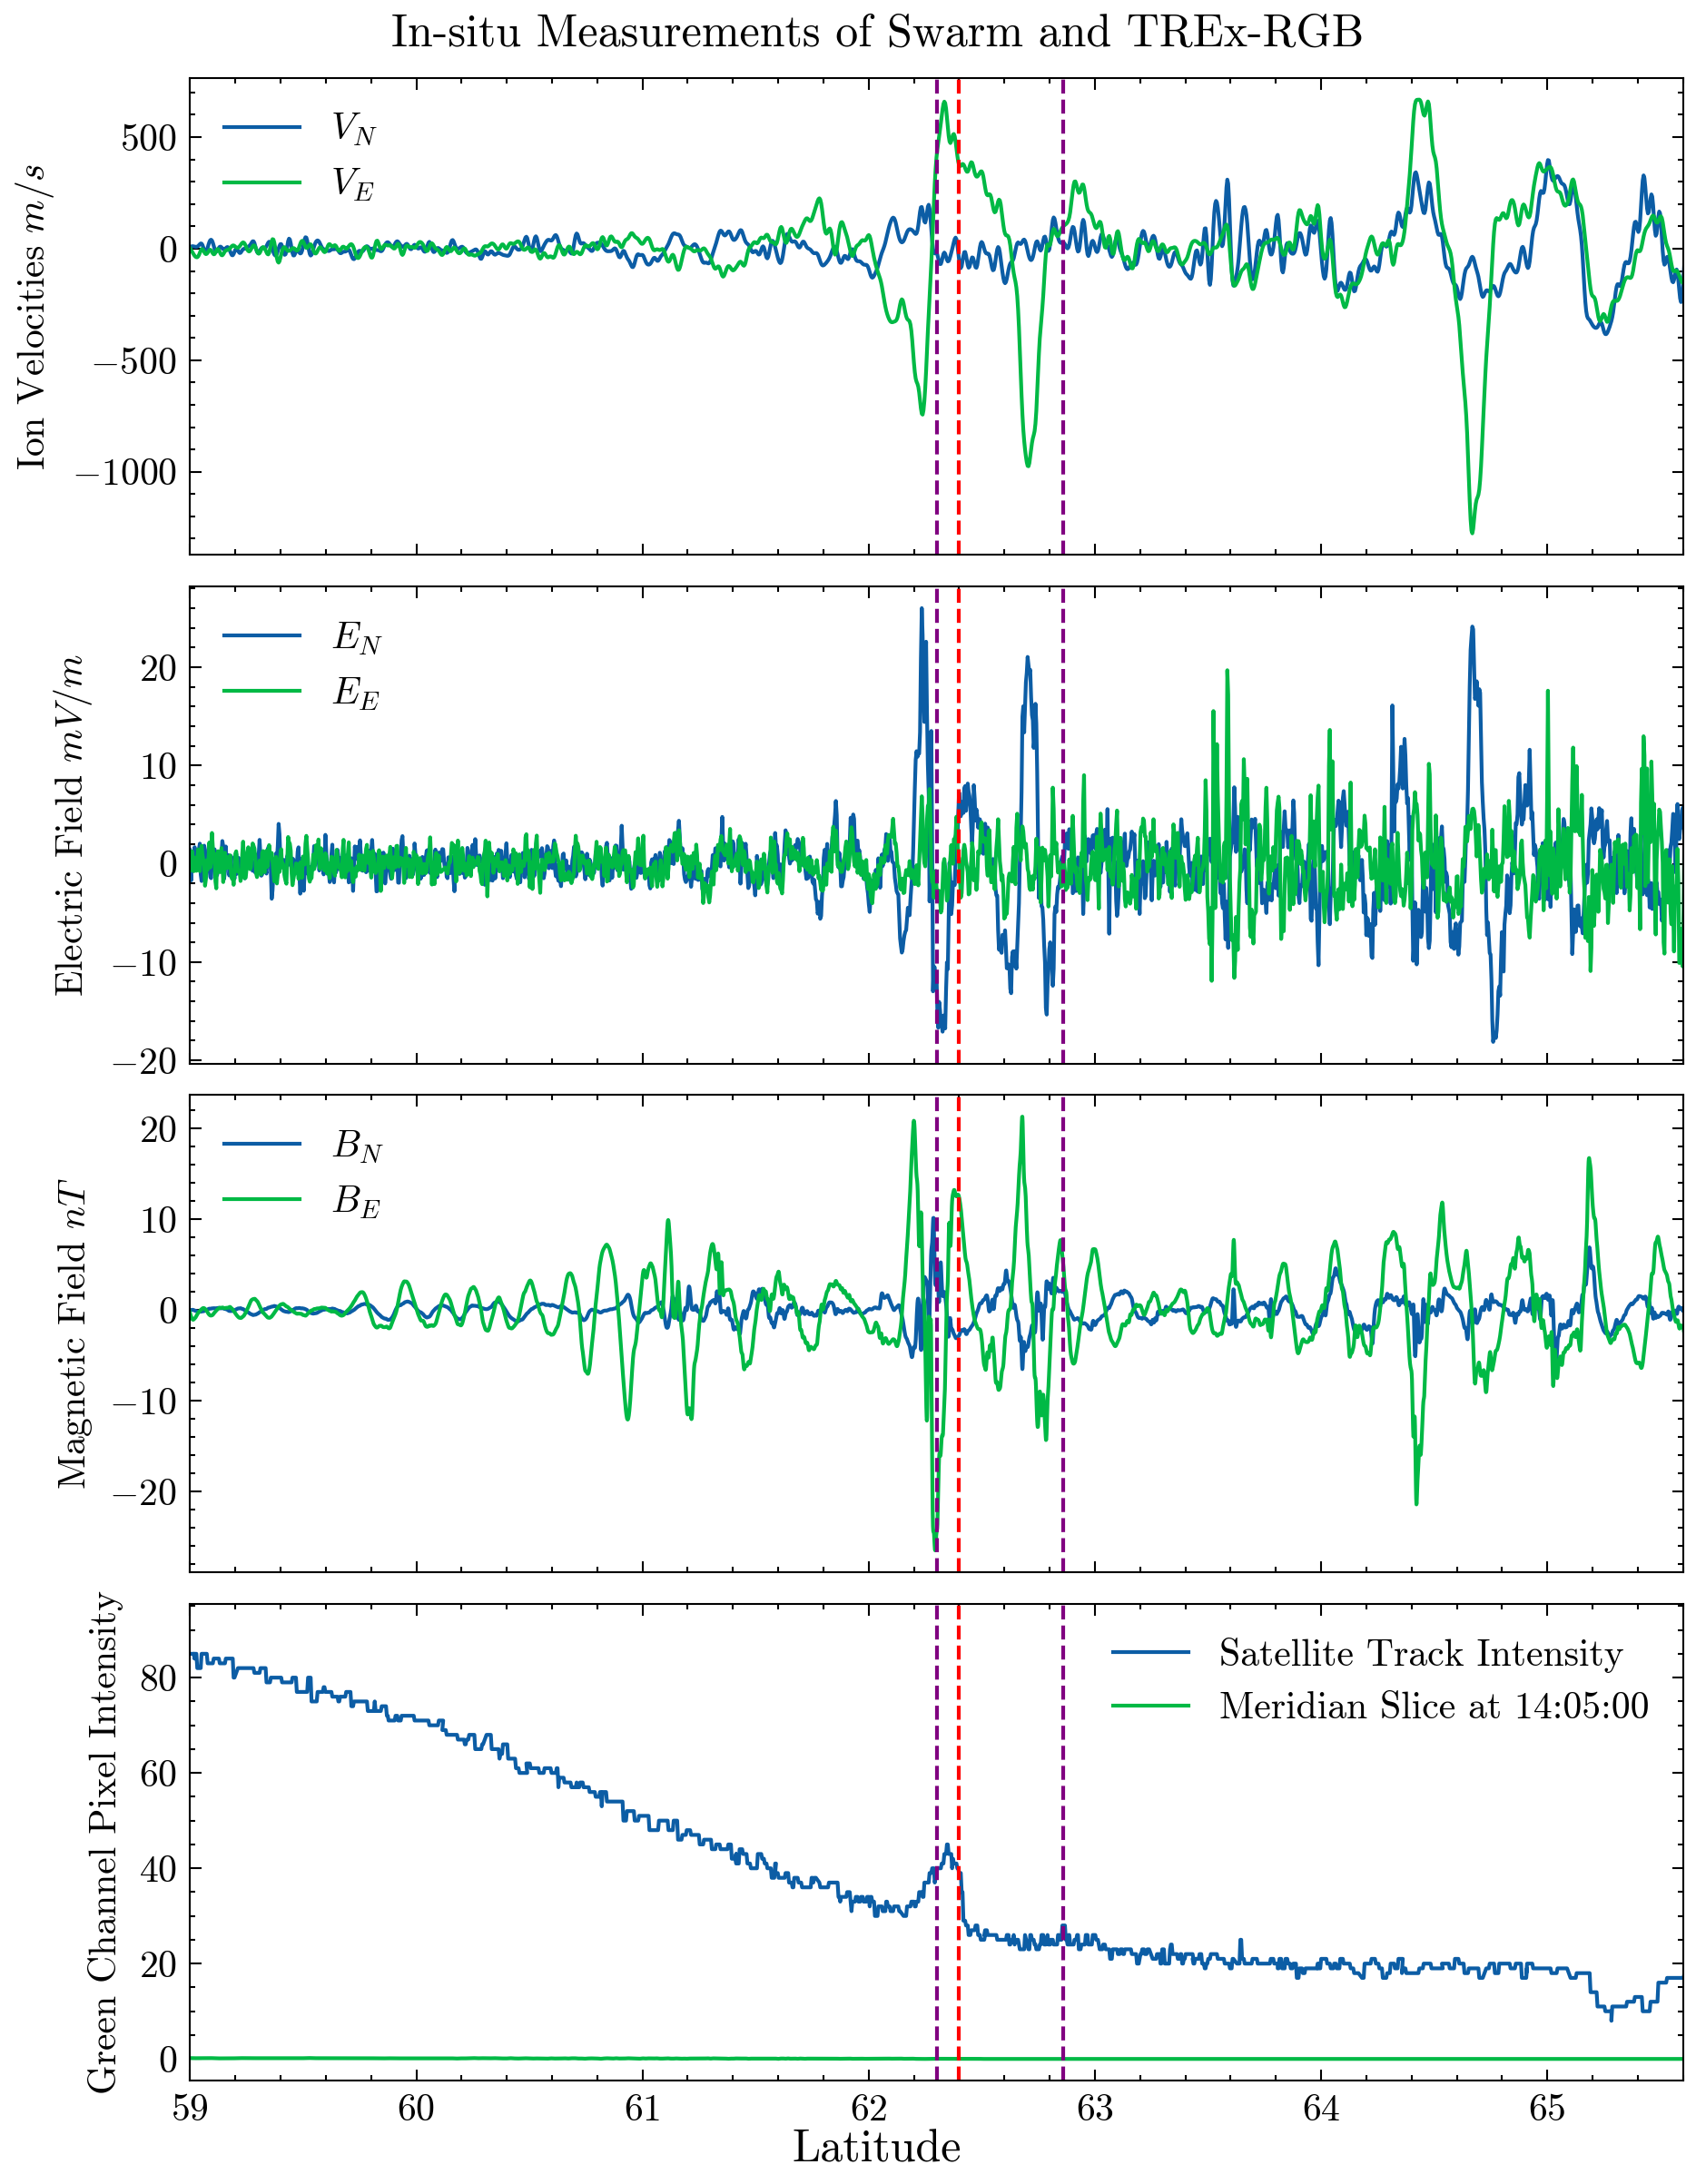

In [132]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V02[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V02[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E02[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E02[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B02[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B02[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_8752\817563030.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

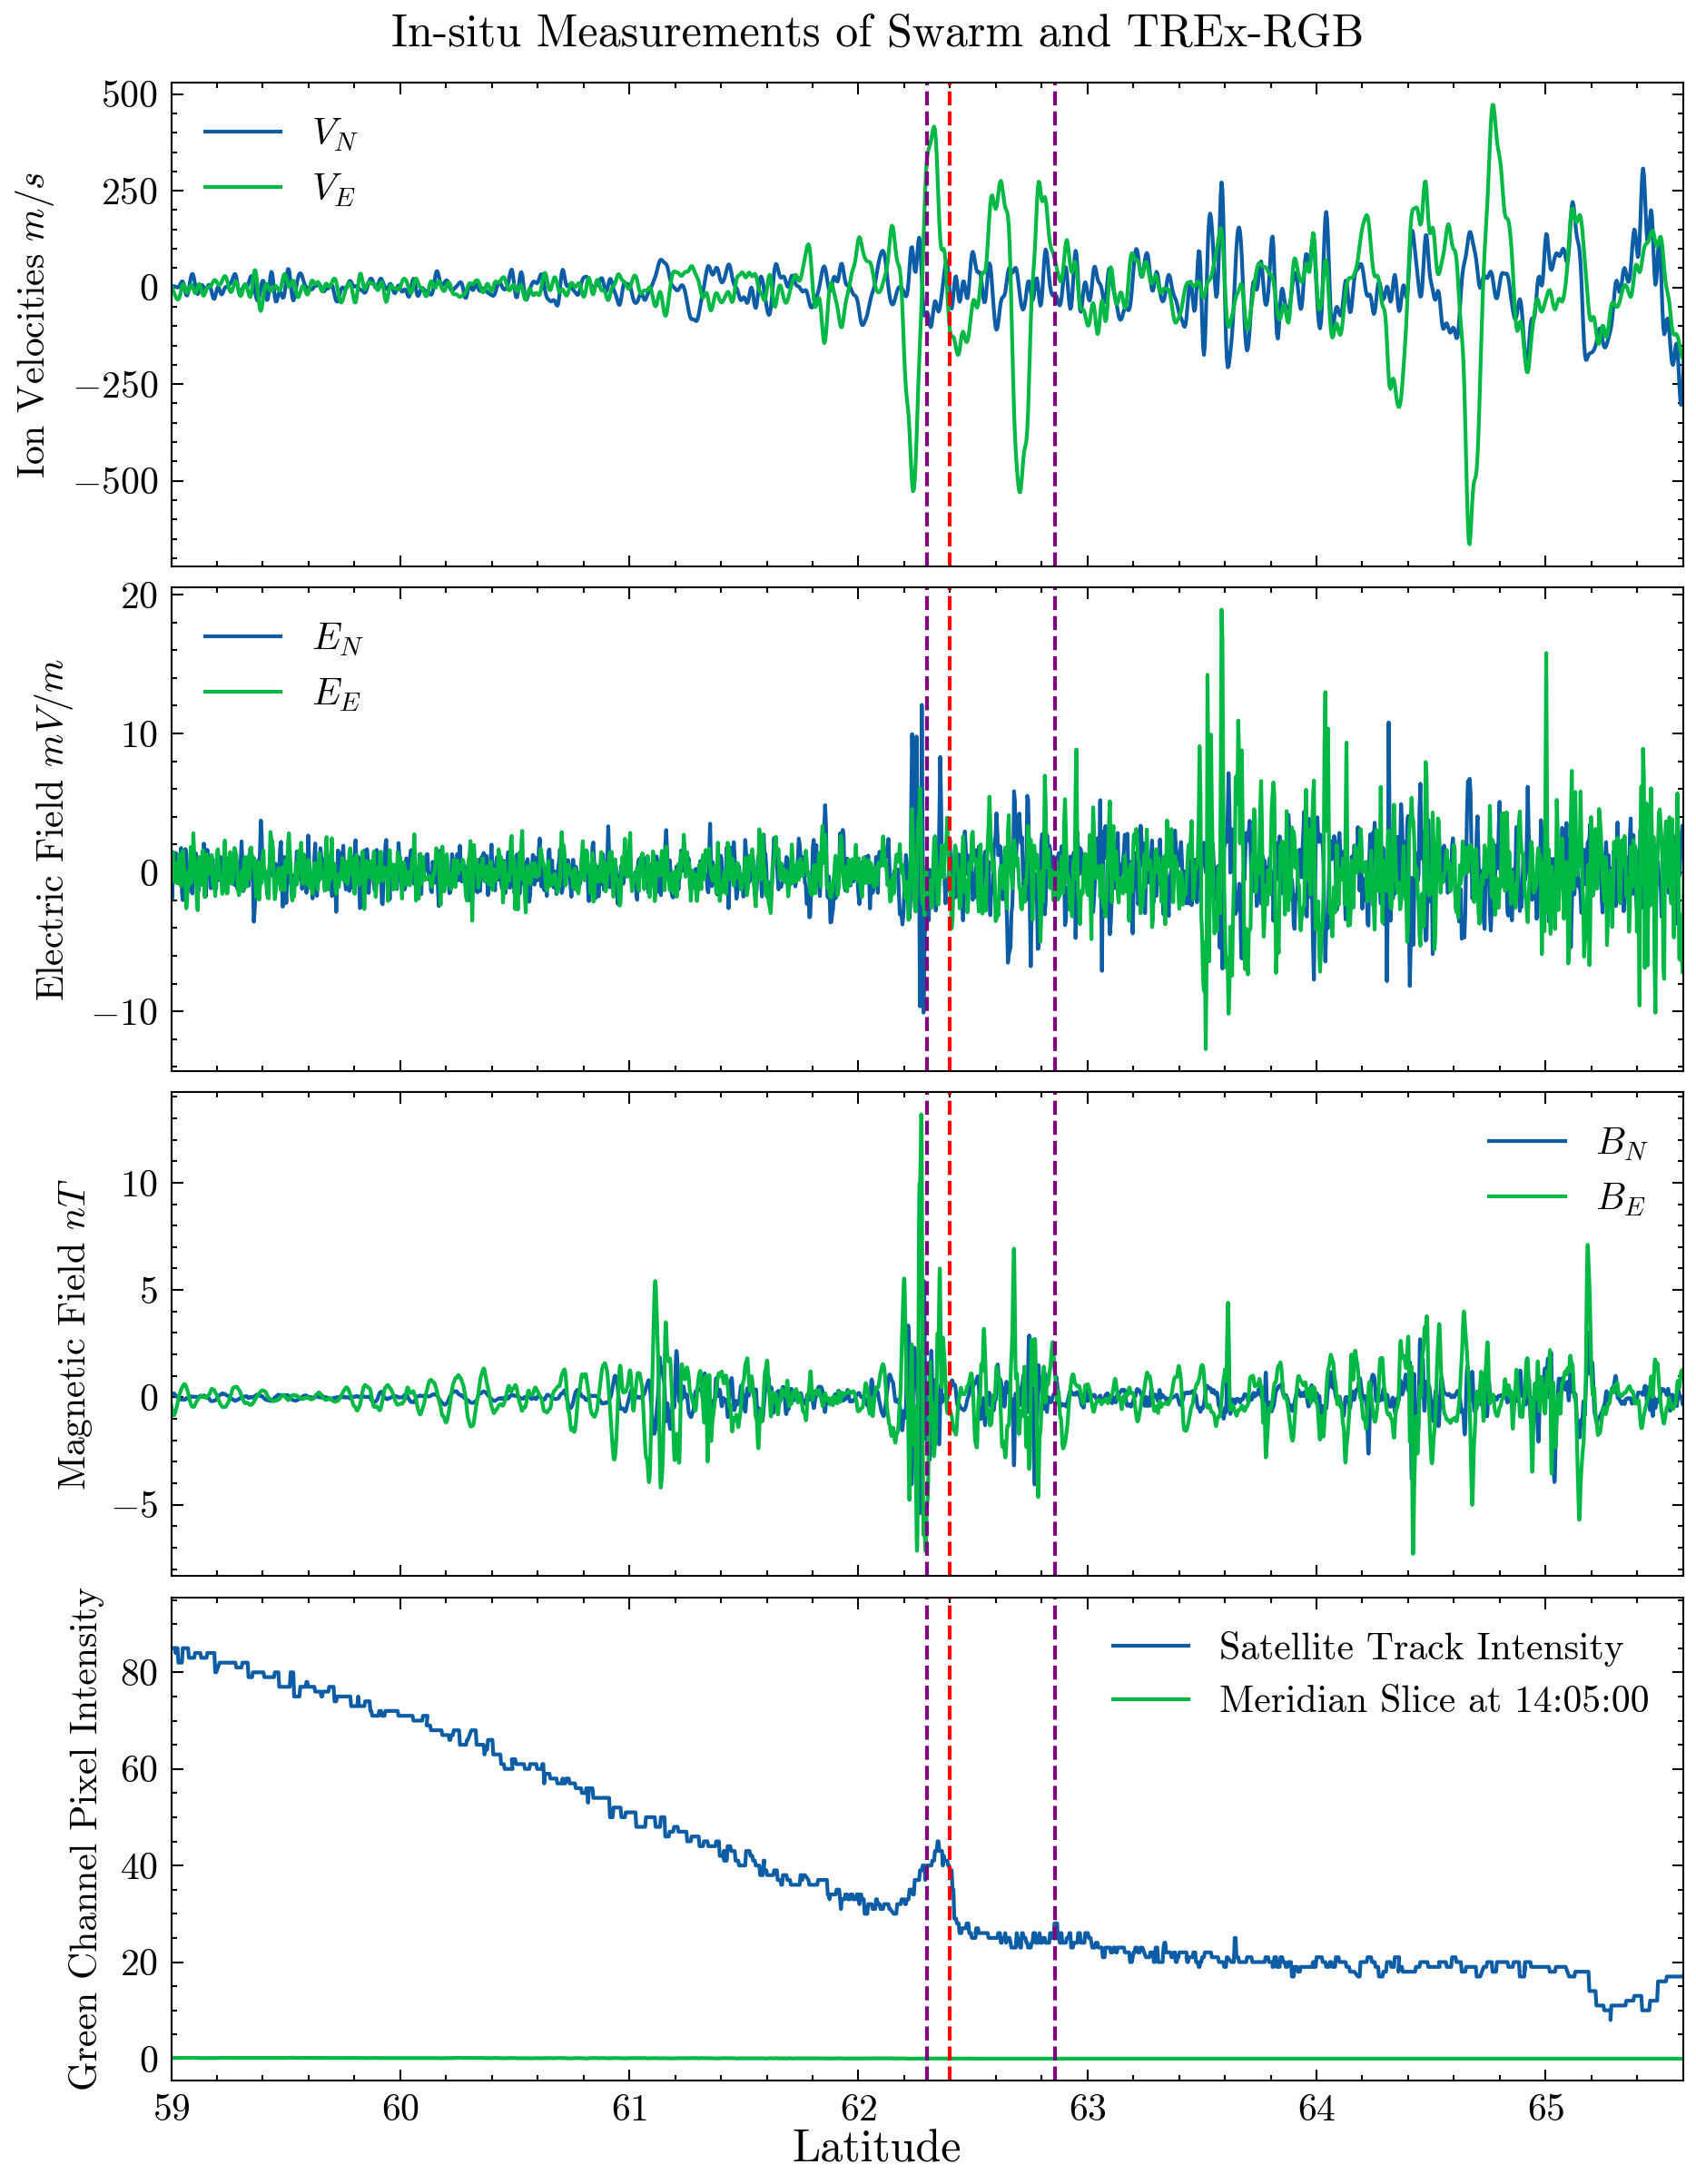

In [133]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V05[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V05[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E05[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E05[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B05[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B05[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)